## Нужные импорты

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Часть 1. Подготовка данных

In [60]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((64, 64)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "data/tiny-imagenet-200"

train_dataset_big = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset_big = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader_big = DataLoader(train_dataset_big, batch_size=8, shuffle=True, num_workers=0)
val_loader_big = DataLoader(val_dataset_big, batch_size=8, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset_big)}")
print(f"Val size: {len(val_dataset_big)}")
print(f"Классов: {len(train_dataset_big.class_names)}")

Train size: 100000
Val size: 10000
Классов: 200


## Визуализация

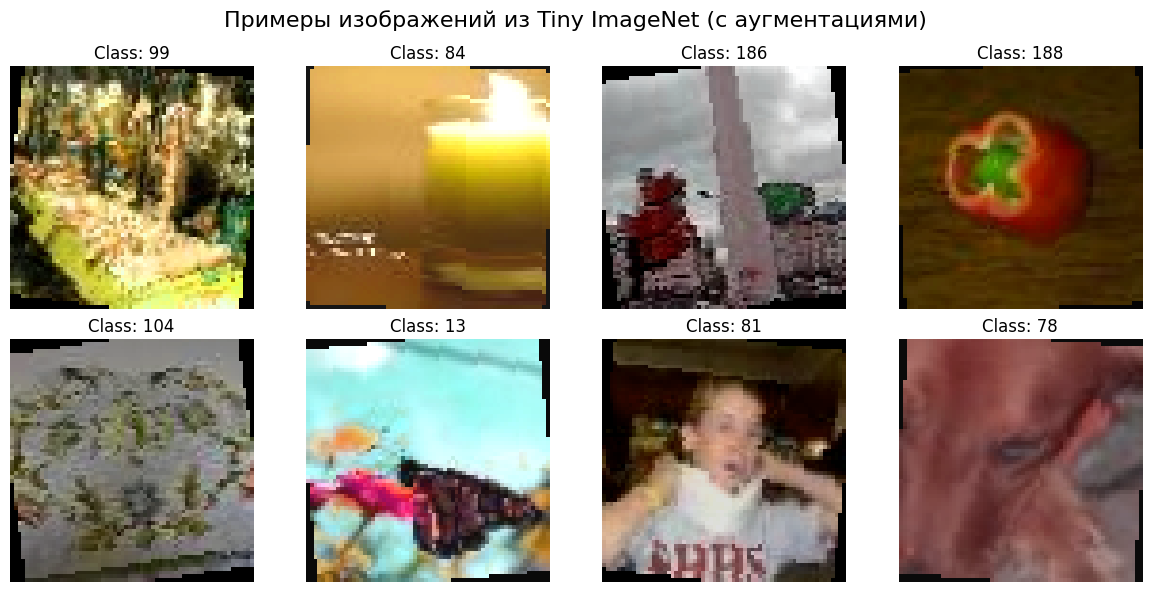

Размер батча: torch.Size([8, 3, 64, 64])
Диапазон значений: [-2.118, 2.640]
Метки классов: [99, 84, 186, 188, 104, 13, 81, 78]
Всего классов в датасете: 200
Примеры названий классов: ['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464']


In [ ]:
images, labels = next(iter(train_loader_big))

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset_big.class_names)}")
print(f"Примеры названий классов: {train_dataset_big.class_names[:8]}")

# Часть 2. Базовая архитектура Resnet18

In [4]:
class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

## Нужные функции для стратификации по эмбеддингам

In [5]:
def extract_and_cluster_embeddings(subset_samples, selected_classes, n_clusters=10, 
                                   batch_size=64, device='auto', return_visualization=False):
    """
    Извлекает эмбеддинги(resnet50), выполняет кластеризацию(K-means) и стратификацию
    
    Args:
        subset_samples: список пар (путь к изображению, метка)
        selected_classes: список выбранных классов
        n_clusters: количество кластеров для K-means
        batch_size: размер батча для извлечения эмбеддингов
        device: 'auto', 'cuda' или 'cpu'
        return_visualization: возвращать ли данные для визуализации (PCA)
    
    Returns:
        train_dataset: датасет для тренировки
        val_dataset: датасет для валидации
        (optional) vis_data: данные для визуализации если return_visualization=True
    """
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    if device == 'auto':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)
        
    # Загружаем ResNet50
    resnet = models.resnet50(pretrained=True)
    resnet = resnet.to(device)
    resnet.eval()
    
    # Feature extractor (без последнего слоя)
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    
    def extract_embeddings(images):
        """Извлекает эмбеддинги из батча изображений"""
        with torch.no_grad():
            x = feature_extractor(images)      # [B, 2048, 1, 1]
            x = x.view(x.size(0), -1)          # [B, 2048]
        return x
    
    # Создаем датасет и загрузчик
    train_subset_dataset_temp = CustomDataset(subset_samples, transform=train_transform)
    temp_loader = DataLoader(train_subset_dataset_temp, batch_size=batch_size, shuffle=False)
    
    # Извлекаем эмбеддинги
    all_embeddings = []
    all_labels = []
    
    for images, labels in tqdm(temp_loader, desc="Извлечение эмбедингов"):
        images = images.to(device)
        emb = extract_embeddings(images)
        all_embeddings.append(emb.cpu())
        all_labels.append(labels)
    
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    print(f"Извлечено {all_embeddings.shape[0]} эмбеддингов, размерность: {all_embeddings.shape[1]}")
    
    # Кластеризация K-means
    print(f"\nКластеризация (K={n_clusters})...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pseudo_labels = kmeans.fit_predict(all_embeddings)
    
    # Анализ соответствия кластеров и классов
    print("Соответствие кластеров исходным классам:")
    cluster_class_mapping = {}
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(pseudo_labels == cluster_id)[0]
        if len(cluster_indices) > 0:
            cluster_classes = all_labels[cluster_indices]
            most_common = Counter(cluster_classes).most_common(1)[0]
            cluster_class_mapping[cluster_id] = most_common
            print(f"  Кластер {cluster_id}: {len(cluster_indices)} образцов, "
                  f"класс {most_common[0]} ({most_common[1]} образцов)")
    
    # Метрики качества кластеризации
    ari_score = adjusted_rand_score(all_labels, pseudo_labels)
    nmi_score = normalized_mutual_info_score(all_labels, pseudo_labels)
    print(f"\nКачество кластеризации:")
    print(f"  Adjusted Rand Index: {ari_score:.3f}")
    print(f"  Normalized Mutual Information: {nmi_score:.3f}")
    
    # Стратификация по кластерам
    print("\nСтратификация по кластерам...")
    sss_embedding = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx_embedding, val_idx_embedding = next(
        sss_embedding.split(subset_samples, pseudo_labels)
    )
    
    train_samples_embedding = [subset_samples[i] for i in train_idx_embedding]
    val_samples_embedding = [subset_samples[i] for i in val_idx_embedding]
    
    print(f"  Train: {len(train_samples_embedding)} образов")
    print(f"  Val: {len(val_samples_embedding)} образцов")
    
    # Анализ распределения
    def analyze_split(samples, name):
        labels = [label for _, label in samples]
        class_counts = Counter(labels)
        print(f"\n{name}:")
        for class_id in selected_classes:
            count = class_counts.get(class_id, 0)
            percentage = count / len(labels) * 100
            print(f"  Класс {class_id}: {count} ({percentage:.1f}%)")
    
    analyze_split(train_samples_embedding, "Train распределение")
    analyze_split(val_samples_embedding, "Val распределение")
    
    # Создаем финальные датасеты
    train_dataset = CustomDataset(train_samples_embedding, transform=train_transform)
    val_dataset = CustomDataset(val_samples_embedding, transform=val_transform)
    
    # Возвращаем результат
    if return_visualization:
        # PCA для визуализации
        pca = PCA(n_components=2, random_state=42)
        emb_2d = pca.fit_transform(all_embeddings)
        
        vis_data = {
            'emb_2d': emb_2d,
            'all_labels': all_labels,
            'pseudo_labels': pseudo_labels,
            'all_embeddings': all_embeddings,
            'cluster_class_mapping': cluster_class_mapping,
            'pca_variance': pca.explained_variance_ratio_,
            'selected_classes': selected_classes,
            'n_clusters': n_clusters
        }
        
        return train_dataset, val_dataset, vis_data
    
    return train_dataset, val_dataset


# Функция для визуализации
def visualize_clustering_results(vis_data):
    """Визуализация результатов кластеризации"""
    
    emb_2d = vis_data['emb_2d']
    all_labels = vis_data['all_labels']
    pseudo_labels = vis_data['pseudo_labels']
    selected_classes = vis_data['selected_classes']
    n_clusters = vis_data['n_clusters']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # По кластерам
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    for cluster in range(n_clusters):
        indices = np.where(pseudo_labels == cluster)[0]
        if len(indices) > 0:
            ax1.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
                       c=[colors[cluster]], label=f'Cluster {cluster}', s=20, alpha=0.7)
    
    ax1.set_title(f"Кластеризация (K={n_clusters})")
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # По исходным классам
    class_colors = plt.cm.Set1(np.linspace(0, 1, len(selected_classes)))
    for i, class_id in enumerate(selected_classes):
        indices = np.where(all_labels == class_id)[0]
        if len(indices) > 0:
            ax2.scatter(emb_2d[indices, 0], emb_2d[indices, 1], 
                       c=[class_colors[i]], label=f'Class {class_id}', s=20, alpha=0.7)
    
    ax2.set_title("Исходные классы")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"PCA объясняет {vis_data['pca_variance'].sum():.3f} дисперсии")
    print("Чем выше значения, тем лучше кластеризация соответствует исходным классам")

## 2.1 Реализация Basic Block

In [15]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Identity()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

        # Тут в сверточных слоях ставят bias = False, так как сдвиг батчнорма его покрывает
        # Также в relu ставят inplace=True

    def forward(self, x):
        x0 = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += x0
        out = self.relu(out)

        return out

basic_block = BasicBlock(64, 128, 2) # из 64 каналов получаем 128 каналов
test_input = torch.randn(2, 64, 32, 32)

output = basic_block(test_input)

## 2.2 Реализация ResNet18

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = self.fc(self.flatten(self.adapavgpool(x)))
        
        return x


model = SimpleResNet18(num_classes=10)
test_input = torch.randn(1, 3, 128, 128)

output = model(test_input)
print(f"Размеры выхода: {output.shape}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

Размеры выхода: torch.Size([1, 10])
Всего параметров: 2,778,058
Обучаемых параметров: 2,778,058


## 2.3 Скрипт обучения

In [17]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпоху
        train_acc: средняя точность за эпоху
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Тренировка ")
    
    for batch_idx, (data, target) in enumerate(pbar):
        data.to(device)
        target.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Предсказания модели
        outputs = model(data)
        
        # Вычисляем loss
        loss = criterion(outputs, target)
        
        # Вычисляем градиенты
        loss.backward()
        
        # Обновляем веса
        optimizer.step()
        
        # Собираем статистику
        running_loss += loss.item()

        # Вычисляем accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
        avg_loss = running_loss / total
        avg_acc = 100 * correct / total
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'acc': f'{avg_acc:.2f}%'
        })

    train_loss = running_loss / total if total > 0 else 0
    train_acc = 100 * correct / total if total > 0 else 0
    
    return train_loss, train_acc


def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации одной эпохи
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря за эпоху
        val_acc: средняя точность за эпоху
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        pbar = tqdm(val_loader, desc="Валидация  ")
        
        for batch_idx, (data, target) in enumerate(pbar):
            data = data.to(device)
            target = target.to(device)
            
            # Предсказания модели
            outputs = model(data)
            
            # Вычисляем loss
            loss = criterion(outputs, target)
            
            # Собираем статистику
            running_loss += loss.item()

            # Вычисляем accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
            
            # Обновляем прогресс-бар
            avg_loss = running_loss / total
            avg_acc = 100 * correct / total
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{avg_acc:.2f}%'
            })

    val_loss = running_loss / total if total > 0 else 0
    val_acc = 100 * correct / total if total > 0 else 0
    
    return val_loss, val_acc

def print_model_summary_and_plot(history, model):
    """
    Выводит информацию о модели и строит графики
    
    Args:
        history: история обучения (словарь)
        model: обученная модель
    """
    import matplotlib.pyplot as plt
    
    print("="*60)
    print("ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
    print("="*60)
    
    print("\n1. АРХИТЕКТУРА МОДЕЛИ:")
    print("-" * 30)
    print(model)
    
    print("\n2. ПАРАМЕТРЫ МОДЕЛИ:")
    print("-" * 30)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    print("\n3. ФИНАЛЬНЫЕ МЕТРИКИ:")
    print("-" * 30)
    print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    
    # Графики
    print("\n4. ГРАФИКИ ОБУЧЕНИЯ:")
    print("-" * 30)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График Accuracy
    ax1.plot(history['train_acc'], label='Train', color='blue', linewidth=2)
    ax1.plot(history['val_acc'], label='Validation', color='red', linewidth=2)
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График Loss
    ax2.plot(history['train_loss'], label='Train', color='blue', linewidth=2)
    ax2.plot(history['val_loss'], label='Validation', color='red', linewidth=2)
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001, 
                optimizer_type='adam', device='cpu', save_file_name='best_model.pth'):
    """
    Полный цикл обучения модели используется criterion = nn.CrossEntropyLoss()
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        num_epochs: количество эпох
        learning_rate: скорость обучения
        optimizer_type: 'adam' или 'sgd'
        device: устройство для обучения ('cpu' или 'cuda')
    
    Returns:
        history: словарь с историей обучения
        best_model: лучшая модель (по accuracy на валидации)
    """
    model = model.to(device)
    print(f"Параметры модели: {sum(p.numel() for p in model.parameters()):,}")
    
    if optimizer_type.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Optimizer: Adam, lr: {learning_rate}")
    elif optimizer_type.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        print(f"Optimizer: SGD, lr: {learning_rate}")
    else:
        raise ValueError("optimizer_type должен быть 'adam' или 'sgd'")
    
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Для сохранения лучшей модели
    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0
    
    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch + 1} из {num_epochs}")
        
        train_loss, train_acc = train_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )
        
        val_loss, val_acc = validate_epoch(
            model=model,
            val_loader=val_loader,
            criterion=criterion,
            device=device
        )
        
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nЭпоха {epoch + 1} Вывод:")
        print(f"Training  |Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Validation|Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
        
        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, save_file_name)
    
    print("Все!")
    print(f"Лучшая acc на валидации   : {best_val_acc:.2f}% это на эпохе {best_epoch}")
    print(f"Финальная acc на трейне   : {history['train_acc'][-1]:.2f}%")
    print(f"Финальная acc на валидации: {history['val_acc'][-1]:.2f}%")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history, model, best_val_acc

## Запуска скрипта

Тут выбираются 10 классов из 200. Я взял первые 10. Делается на них эмбеддинг, и обучение и валидация берется из train. val будет использоваться потом для проверки модели, поскольку test не походит для этого, так как он не размечен

In [ ]:
selected_classes = [i for i in range(0, 10)] # чтобы сразу класс соответсвовал индеку, иначе пришлось бы чет делать с нумерацией

subset_samples = [s for s in train_dataset_big.samples if s[1] in selected_classes] # выбраю те, у которых label из selected_classes
test_subset_samples = [s for s in val_dataset_big.samples if s[1] in selected_classes] # валидация идет на тест

print(f"Используем {len(subset_samples)} изображений из {len(selected_classes)} классов")
print(f"Выбранные классы: {selected_classes}")

# Стратификация
train_dataset, val_dataset, vis_data = extract_and_cluster_embeddings(
    subset_samples=subset_samples,
    selected_classes=selected_classes,
    n_clusters=15,
    batch_size=64,
    return_visualization=True
)

Используем 5000 изображений из 10 классов
Выбранные классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\neural_networks\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Извлечение эмбедингов: 100%|██████████| 79/79 [00:15<00:00,  5.05it/s]


Извлечено 5000 эмбеддингов, размерность: 2048

Кластеризация (K=15)...
Соответствие кластеров исходным классам:
  Кластер 0: 346 образцов, класс 8 (139 образцов)
  Кластер 1: 252 образцов, класс 1 (154 образцов)
  Кластер 2: 437 образцов, класс 7 (315 образцов)
  Кластер 3: 176 образцов, класс 0 (168 образцов)
  Кластер 4: 185 образцов, класс 8 (136 образцов)
  Кластер 5: 447 образцов, класс 6 (187 образцов)
  Кластер 6: 542 образцов, класс 2 (183 образцов)
  Кластер 7: 171 образцов, класс 4 (148 образцов)
  Кластер 8: 692 образцов, класс 5 (311 образцов)
  Кластер 9: 379 образцов, класс 0 (103 образцов)
  Кластер 10: 174 образцов, класс 4 (161 образцов)
  Кластер 11: 306 образцов, класс 3 (169 образцов)
  Кластер 12: 180 образцов, класс 8 (176 образцов)
  Кластер 13: 627 образцов, класс 3 (152 образцов)
  Кластер 14: 86 образцов, класс 5 (70 образцов)

Качество кластеризации:
  Adjusted Rand Index: 0.204
  Normalized Mutual Information: 0.356

Стратификация по кластерам...
  Train: 40

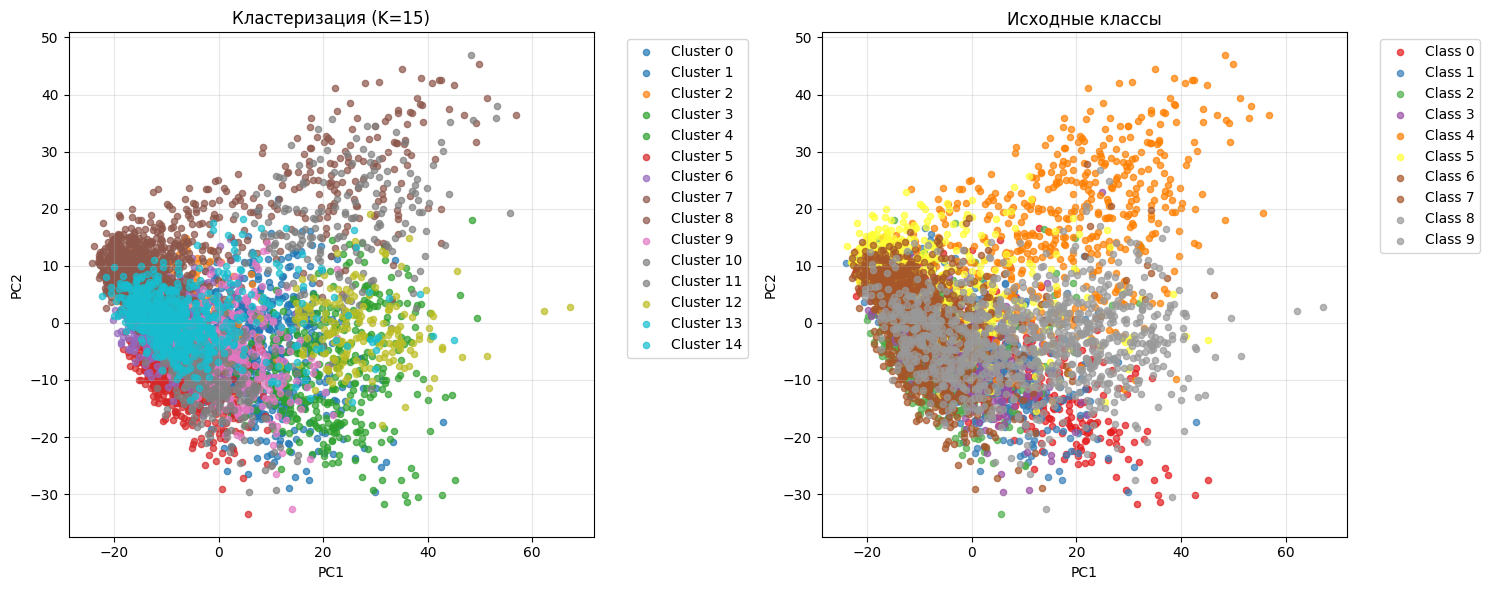

PCA объясняет 0.128 дисперсии
Чем выше значения, тем лучше кластеризация соответствует исходным классам


In [19]:
visualize_clustering_results(vis_data)

In [20]:
model = SimpleResNet18(num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Train : {len(train_loader)} бачей, {len(train_dataset)} изображений")
print(f"Val   : {len(val_loader)} бачей, {len(val_dataset)} изображений")

# Это в 3 пункте будет вариантом B, поэтому сразу так называею
history_B, model_B, best_val_acc_B = train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_B.pth'
)

Train : 63 бачей, 4000 изображений
Val   : 16 бачей, 1000 изображений
Параметры модели: 2,778,058
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0298, acc=34.50%]



Эпоха 1 Вывод:
Training  |Loss: 0.0311 | Acc: 30.93%
Validation|Loss: 0.0298 | Acc: 34.50%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.40it/s, loss=0.0271, acc=42.60%]



Эпоха 2 Вывод:
Training  |Loss: 0.0277 | Acc: 37.85%
Validation|Loss: 0.0271 | Acc: 42.60%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.48it/s, loss=0.0252, acc=47.50%]



Эпоха 3 Вывод:
Training  |Loss: 0.0262 | Acc: 41.95%
Validation|Loss: 0.0252 | Acc: 47.50%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.87it/s, loss=0.0254, acc=42.50%]



Эпоха 4 Вывод:
Training  |Loss: 0.0248 | Acc: 46.40%
Validation|Loss: 0.0254 | Acc: 42.50%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, loss=0.0245, acc=46.20%]



Эпоха 5 Вывод:
Training  |Loss: 0.0227 | Acc: 49.98%
Validation|Loss: 0.0245 | Acc: 46.20%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.98it/s, loss=0.0247, acc=46.20%]



Эпоха 6 Вывод:
Training  |Loss: 0.0216 | Acc: 52.75%
Validation|Loss: 0.0247 | Acc: 46.20%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.14it/s, loss=0.0259, acc=46.10%]



Эпоха 7 Вывод:
Training  |Loss: 0.0214 | Acc: 53.40%
Validation|Loss: 0.0259 | Acc: 46.10%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.05it/s, loss=0.0263, acc=43.90%]



Эпоха 8 Вывод:
Training  |Loss: 0.0204 | Acc: 55.23%
Validation|Loss: 0.0263 | Acc: 43.90%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.07it/s, loss=0.0206, acc=55.90%]



Эпоха 9 Вывод:
Training  |Loss: 0.0199 | Acc: 56.40%
Validation|Loss: 0.0206 | Acc: 55.90%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.96it/s, loss=0.0192, acc=60.30%]



Эпоха 10 Вывод:
Training  |Loss: 0.0190 | Acc: 58.58%
Validation|Loss: 0.0192 | Acc: 60.30%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.03it/s, loss=0.0203, acc=57.30%]



Эпоха 11 Вывод:
Training  |Loss: 0.0180 | Acc: 60.52%
Validation|Loss: 0.0203 | Acc: 57.30%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.78it/s, loss=0.0227, acc=52.80%]



Эпоха 12 Вывод:
Training  |Loss: 0.0183 | Acc: 59.55%
Validation|Loss: 0.0227 | Acc: 52.80%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.86it/s, loss=0.0206, acc=56.10%]



Эпоха 13 Вывод:
Training  |Loss: 0.0173 | Acc: 62.17%
Validation|Loss: 0.0206 | Acc: 56.10%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0201, acc=57.10%]



Эпоха 14 Вывод:
Training  |Loss: 0.0167 | Acc: 63.90%
Validation|Loss: 0.0201 | Acc: 57.10%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0193, acc=61.00%]



Эпоха 15 Вывод:
Training  |Loss: 0.0166 | Acc: 63.27%
Validation|Loss: 0.0193 | Acc: 61.00%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0206, acc=59.10%]



Эпоха 16 Вывод:
Training  |Loss: 0.0161 | Acc: 65.50%
Validation|Loss: 0.0206 | Acc: 59.10%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0173, acc=63.30%]



Эпоха 17 Вывод:
Training  |Loss: 0.0156 | Acc: 65.75%
Validation|Loss: 0.0173 | Acc: 63.30%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0206, acc=58.20%]



Эпоха 18 Вывод:
Training  |Loss: 0.0149 | Acc: 67.50%
Validation|Loss: 0.0206 | Acc: 58.20%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.19it/s, loss=0.0174, acc=64.70%]



Эпоха 19 Вывод:
Training  |Loss: 0.0148 | Acc: 67.65%
Validation|Loss: 0.0174 | Acc: 64.70%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.66it/s, loss=0.0192, acc=61.30%]


Эпоха 20 Вывод:
Training  |Loss: 0.0145 | Acc: 69.08%
Validation|Loss: 0.0192 | Acc: 61.30%
Все!
Лучшая acc на валидации   : 64.70% это на эпохе 19
Финальная acc на трейне   : 69.08%
Финальная acc на валидации: 61.30%


# Часть 3. Поэтапная оптимизация модели

## 3.1. Оптимизация количества каналов

Вариант A: 32 → 64 → 128 → 256 каналов

Вариант B: это по сути то, что я обучал выше

In [22]:
class SimpleResNet18_A(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1_0 = BasicBlock(32, 32)
        self.basic_block_1_1 = BasicBlock(32, 32)

        self.basic_block_2_0 = BasicBlock(32, 64, stride=2)
        self.basic_block_2_1 = BasicBlock(64, 64)

        self.basic_block_3_0 = BasicBlock(64, 128, stride=2)
        self.basic_block_3_1 = BasicBlock(128, 128)

        self.basic_block_4_0 = BasicBlock(128, 256, stride=2)
        self.basic_block_4_1 = BasicBlock(256, 256)

        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x)) 

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x

In [23]:
num_epochs = 20

model_A = SimpleResNet18_A(num_classes=10)

history_A, model_A, best_val_acc_A = train_model(
    model=model_A, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_A.pth'
)

Параметры модели: 2,798,058
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Тренировка :   0%|          | 0/63 [00:00<?, ?it/s]

Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.04it/s, loss=0.0292, acc=35.70%]



Эпоха 1 Вывод:
Training  |Loss: 0.0312 | Acc: 31.12%
Validation|Loss: 0.0292 | Acc: 35.70%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.57it/s, loss=0.0337, acc=31.90%]



Эпоха 2 Вывод:
Training  |Loss: 0.0270 | Acc: 39.48%
Validation|Loss: 0.0337 | Acc: 31.90%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.42it/s, loss=0.0316, acc=36.40%]



Эпоха 3 Вывод:
Training  |Loss: 0.0256 | Acc: 43.02%
Validation|Loss: 0.0316 | Acc: 36.40%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.59it/s, loss=0.0245, acc=45.30%]



Эпоха 4 Вывод:
Training  |Loss: 0.0234 | Acc: 49.02%
Validation|Loss: 0.0245 | Acc: 45.30%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.31it/s, loss=0.0237, acc=50.60%]



Эпоха 5 Вывод:
Training  |Loss: 0.0224 | Acc: 50.95%
Validation|Loss: 0.0237 | Acc: 50.60%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.12it/s, loss=0.0227, acc=52.20%]



Эпоха 6 Вывод:
Training  |Loss: 0.0213 | Acc: 53.98%
Validation|Loss: 0.0227 | Acc: 52.20%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.62it/s, loss=0.0216, acc=53.50%]



Эпоха 7 Вывод:
Training  |Loss: 0.0202 | Acc: 56.08%
Validation|Loss: 0.0216 | Acc: 53.50%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.73it/s, loss=0.0274, acc=47.40%]



Эпоха 8 Вывод:
Training  |Loss: 0.0197 | Acc: 57.27%
Validation|Loss: 0.0274 | Acc: 47.40%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 10.73it/s, loss=0.0244, acc=50.90%]



Эпоха 9 Вывод:
Training  |Loss: 0.0185 | Acc: 59.08%
Validation|Loss: 0.0244 | Acc: 50.90%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.22it/s, loss=0.0221, acc=54.20%]



Эпоха 10 Вывод:
Training  |Loss: 0.0180 | Acc: 61.60%
Validation|Loss: 0.0221 | Acc: 54.20%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.09it/s, loss=0.0213, acc=56.40%]



Эпоха 11 Вывод:
Training  |Loss: 0.0176 | Acc: 61.23%
Validation|Loss: 0.0213 | Acc: 56.40%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.20it/s, loss=0.0187, acc=58.40%]



Эпоха 12 Вывод:
Training  |Loss: 0.0169 | Acc: 62.95%
Validation|Loss: 0.0187 | Acc: 58.40%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.31it/s, loss=0.0220, acc=55.90%]



Эпоха 13 Вывод:
Training  |Loss: 0.0164 | Acc: 64.50%
Validation|Loss: 0.0220 | Acc: 55.90%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0213, acc=56.20%]



Эпоха 14 Вывод:
Training  |Loss: 0.0156 | Acc: 65.97%
Validation|Loss: 0.0213 | Acc: 56.20%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.55it/s, loss=0.0205, acc=57.80%]



Эпоха 15 Вывод:
Training  |Loss: 0.0153 | Acc: 65.65%
Validation|Loss: 0.0205 | Acc: 57.80%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.65it/s, loss=0.0219, acc=55.50%]



Эпоха 16 Вывод:
Training  |Loss: 0.0148 | Acc: 67.95%
Validation|Loss: 0.0219 | Acc: 55.50%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.77it/s, loss=0.0179, acc=62.70%]



Эпоха 17 Вывод:
Training  |Loss: 0.0142 | Acc: 68.70%
Validation|Loss: 0.0179 | Acc: 62.70%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.37it/s, loss=0.0189, acc=63.90%]



Эпоха 18 Вывод:
Training  |Loss: 0.0137 | Acc: 69.83%
Validation|Loss: 0.0189 | Acc: 63.90%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.63it/s, loss=0.0198, acc=61.90%]



Эпоха 19 Вывод:
Training  |Loss: 0.0132 | Acc: 70.55%
Validation|Loss: 0.0198 | Acc: 61.90%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00, 11.67it/s, loss=0.0192, acc=61.10%]


Эпоха 20 Вывод:
Training  |Loss: 0.0130 | Acc: 71.00%
Validation|Loss: 0.0192 | Acc: 61.10%
Все!
Лучшая acc на валидации   : 63.90% это на эпохе 18
Финальная acc на трейне   : 71.00%
Финальная acc на валидации: 61.10%


ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ

1. АРХИТЕКТУРА МОДЕЛИ:
------------------------------
SimpleResNet18_A(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Identity()
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (b

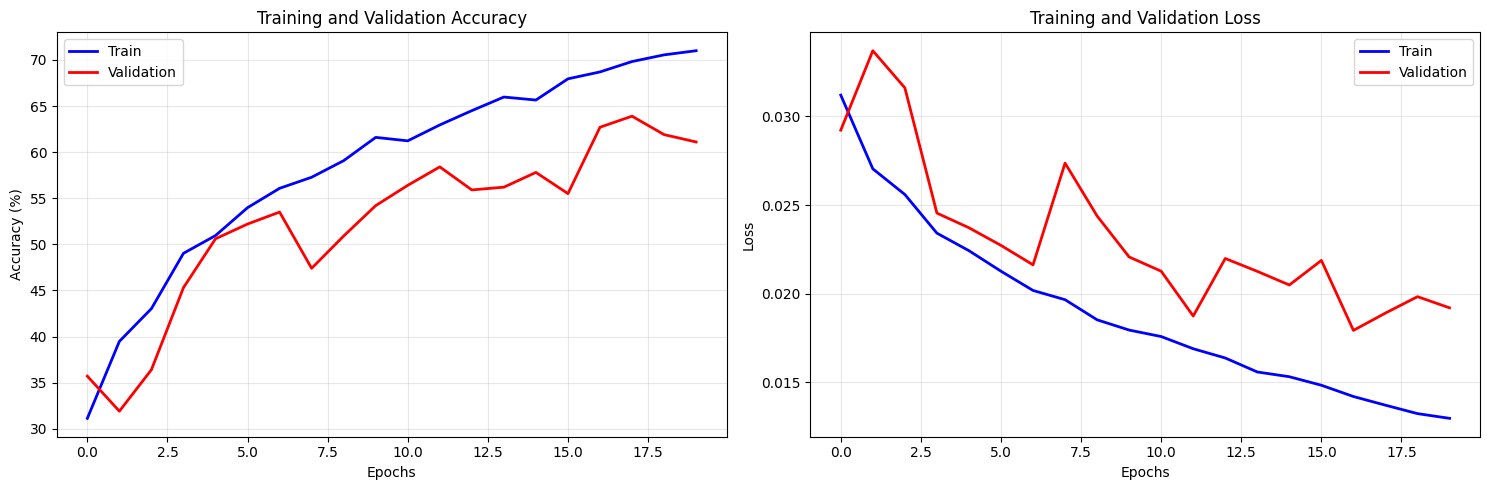

In [24]:
print_model_summary_and_plot(history_A, model_A)

ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ

1. АРХИТЕКТУРА МОДЕЛИ:
------------------------------
SimpleResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Identity()
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1

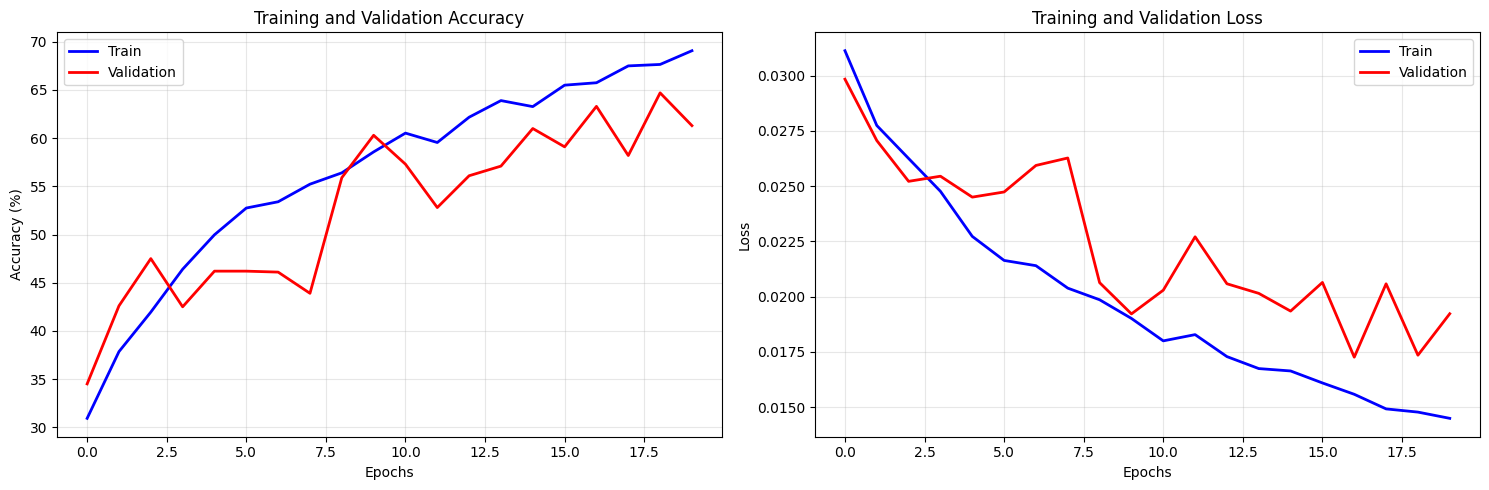

In [25]:
print_model_summary_and_plot(history_B, model_B)

In [26]:
total_params_A = sum(p.numel() for p in model_A.parameters())
trainable_params_A = sum(p.numel() for p in model_A.parameters() if p.requires_grad)
print(f" Всего параметров варианта А: {total_params_A}")
print(f" Обучаемых параметров варианта А: {trainable_params_A}")

total_params_B = sum(p.numel() for p in model_B.parameters())
trainable_params_B = sum(p.numel() for p in model_B.parameters() if p.requires_grad)
print(f" Всего параметров варианта B: {total_params_B}")
print(f" Обучаемых параметров варианта B: {trainable_params_B}")

print(f"Лучшая acc для варинаты A: {best_val_acc_A}")
print(f"Лучшая acc для варинаты B: {best_val_acc_B}")

 Всего параметров варианта А: 2798058
 Обучаемых параметров варианта А: 2798058
 Всего параметров варианта B: 2778058
 Обучаемых параметров варианта B: 2778058
Лучшая acc для варинаты A: 63.9
Лучшая acc для варинаты B: 64.7


Дальше использует вариант B, поскольку у него больше точность на валидации

## 3.2. Эксперименты с количеством residual блоков


In [27]:
def plot_acc(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for h in history:
        ax1.plot(h[0]['train_acc'], label=h[1])

    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    for h in history:
        ax2.plot(h[0]['val_acc'], label=h[1])

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [31]:
class SimpleResNet18_Small(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1 = BasicBlock(64, 64)

        self.basic_block_2 = BasicBlock(64, 128, stride=2)

        self.basic_block_3 = BasicBlock(128, 256, stride=2)

        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1(x)
        x = self.basic_block_2(x)
        x = self.basic_block_3(x)

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x
    
class SimpleResNet18_Standart(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x

class SimpleResNet18_Large(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)
        self.basic_block_1_2 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, stride=2)
        self.basic_block_2_1 = BasicBlock(128, 128)
        self.basic_block_2_2 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, stride=2)
        self.basic_block_3_1 = BasicBlock(256, 256)
        self.basic_block_3_2 = BasicBlock(256, 256)
        
        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1_2(self.basic_block_1_1(self.basic_block_1_0(x)))
        x = self.basic_block_2_2(self.basic_block_2_1(self.basic_block_2_0(x)))
        x = self.basic_block_3_2(self.basic_block_3_1(self.basic_block_3_0(x)))

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x

In [29]:
model_small = SimpleResNet18_Small(num_classes=10)

history_small, model_small, best_val_acc_small = train_model(
    model=model_small, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_small.pth'
)

Параметры модели: 1,227,978
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.84it/s, loss=0.0322, acc=30.10%]



Эпоха 1 Вывод:
Training  |Loss: 0.0306 | Acc: 31.93%
Validation|Loss: 0.0322 | Acc: 30.10%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.24it/s, loss=0.0304, acc=37.70%]



Эпоха 2 Вывод:
Training  |Loss: 0.0273 | Acc: 39.83%
Validation|Loss: 0.0304 | Acc: 37.70%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.29it/s, loss=0.0269, acc=39.00%]



Эпоха 3 Вывод:
Training  |Loss: 0.0255 | Acc: 44.88%
Validation|Loss: 0.0269 | Acc: 39.00%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.47it/s, loss=0.0270, acc=41.60%]



Эпоха 4 Вывод:
Training  |Loss: 0.0232 | Acc: 50.17%
Validation|Loss: 0.0270 | Acc: 41.60%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.56it/s, loss=0.0253, acc=45.50%]



Эпоха 5 Вывод:
Training  |Loss: 0.0223 | Acc: 52.10%
Validation|Loss: 0.0253 | Acc: 45.50%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.23it/s, loss=0.0213, acc=54.30%]



Эпоха 6 Вывод:
Training  |Loss: 0.0213 | Acc: 53.08%
Validation|Loss: 0.0213 | Acc: 54.30%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.31it/s, loss=0.0251, acc=45.50%]



Эпоха 7 Вывод:
Training  |Loss: 0.0203 | Acc: 56.20%
Validation|Loss: 0.0251 | Acc: 45.50%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.41it/s, loss=0.0219, acc=53.60%]



Эпоха 8 Вывод:
Training  |Loss: 0.0198 | Acc: 56.30%
Validation|Loss: 0.0219 | Acc: 53.60%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.28it/s, loss=0.0278, acc=42.80%]



Эпоха 9 Вывод:
Training  |Loss: 0.0186 | Acc: 59.12%
Validation|Loss: 0.0278 | Acc: 42.80%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.42it/s, loss=0.0225, acc=53.00%]



Эпоха 10 Вывод:
Training  |Loss: 0.0188 | Acc: 58.92%
Validation|Loss: 0.0225 | Acc: 53.00%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.05it/s, loss=0.0206, acc=57.30%]



Эпоха 11 Вывод:
Training  |Loss: 0.0180 | Acc: 61.20%
Validation|Loss: 0.0206 | Acc: 57.30%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.07it/s, loss=0.0196, acc=60.00%]



Эпоха 12 Вывод:
Training  |Loss: 0.0177 | Acc: 62.40%
Validation|Loss: 0.0196 | Acc: 60.00%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.73it/s, loss=0.0201, acc=58.40%]



Эпоха 13 Вывод:
Training  |Loss: 0.0172 | Acc: 61.50%
Validation|Loss: 0.0201 | Acc: 58.40%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.24it/s, loss=0.0187, acc=58.80%]



Эпоха 14 Вывод:
Training  |Loss: 0.0168 | Acc: 63.77%
Validation|Loss: 0.0187 | Acc: 58.80%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.05it/s, loss=0.0178, acc=61.80%]



Эпоха 15 Вывод:
Training  |Loss: 0.0159 | Acc: 65.60%
Validation|Loss: 0.0178 | Acc: 61.80%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.06it/s, loss=0.0230, acc=53.20%]



Эпоха 16 Вывод:
Training  |Loss: 0.0156 | Acc: 66.45%
Validation|Loss: 0.0230 | Acc: 53.20%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.22it/s, loss=0.0197, acc=57.90%]



Эпоха 17 Вывод:
Training  |Loss: 0.0154 | Acc: 66.58%
Validation|Loss: 0.0197 | Acc: 57.90%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.98it/s, loss=0.0178, acc=62.70%]



Эпоха 18 Вывод:
Training  |Loss: 0.0151 | Acc: 66.33%
Validation|Loss: 0.0178 | Acc: 62.70%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.09it/s, loss=0.0248, acc=50.10%]



Эпоха 19 Вывод:
Training  |Loss: 0.0146 | Acc: 67.35%
Validation|Loss: 0.0248 | Acc: 50.10%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.01it/s, loss=0.0167, acc=63.40%]


Эпоха 20 Вывод:
Training  |Loss: 0.0145 | Acc: 68.35%
Validation|Loss: 0.0167 | Acc: 63.40%
Все!
Лучшая acc на валидации   : 63.40% это на эпохе 20
Финальная acc на трейне   : 68.35%
Финальная acc на валидации: 63.40%


In [32]:
model_standart = SimpleResNet18_Standart(num_classes=10)

history_standart, model_standart, best_val_acc_standart = train_model(
    model=model_standart, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_standart.pth'
)

Параметры модели: 2,778,058
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.01it/s, loss=0.0360, acc=28.60%]



Эпоха 1 Вывод:
Training  |Loss: 0.0318 | Acc: 29.75%
Validation|Loss: 0.0360 | Acc: 28.60%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, loss=0.0301, acc=33.30%]



Эпоха 2 Вывод:
Training  |Loss: 0.0278 | Acc: 38.23%
Validation|Loss: 0.0301 | Acc: 33.30%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.45it/s, loss=0.0289, acc=38.90%]



Эпоха 3 Вывод:
Training  |Loss: 0.0260 | Acc: 43.12%
Validation|Loss: 0.0289 | Acc: 38.90%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.13it/s, loss=0.0355, acc=36.10%]



Эпоха 4 Вывод:
Training  |Loss: 0.0243 | Acc: 47.48%
Validation|Loss: 0.0355 | Acc: 36.10%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.03it/s, loss=0.0235, acc=48.40%]



Эпоха 5 Вывод:
Training  |Loss: 0.0227 | Acc: 51.38%
Validation|Loss: 0.0235 | Acc: 48.40%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.86it/s, loss=0.0249, acc=49.70%]



Эпоха 6 Вывод:
Training  |Loss: 0.0218 | Acc: 52.73%
Validation|Loss: 0.0249 | Acc: 49.70%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.88it/s, loss=0.0253, acc=47.60%]



Эпоха 7 Вывод:
Training  |Loss: 0.0210 | Acc: 53.90%
Validation|Loss: 0.0253 | Acc: 47.60%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.75it/s, loss=0.0256, acc=47.10%]



Эпоха 8 Вывод:
Training  |Loss: 0.0200 | Acc: 56.20%
Validation|Loss: 0.0256 | Acc: 47.10%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.72it/s, loss=0.0219, acc=54.40%]



Эпоха 9 Вывод:
Training  |Loss: 0.0190 | Acc: 58.42%
Validation|Loss: 0.0219 | Acc: 54.40%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.73it/s, loss=0.0191, acc=60.70%]



Эпоха 10 Вывод:
Training  |Loss: 0.0190 | Acc: 58.62%
Validation|Loss: 0.0191 | Acc: 60.70%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.14it/s, loss=0.0189, acc=59.10%]



Эпоха 11 Вывод:
Training  |Loss: 0.0182 | Acc: 60.10%
Validation|Loss: 0.0189 | Acc: 59.10%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, loss=0.0198, acc=58.00%]



Эпоха 12 Вывод:
Training  |Loss: 0.0175 | Acc: 61.98%
Validation|Loss: 0.0198 | Acc: 58.00%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.58it/s, loss=0.0238, acc=53.10%]



Эпоха 13 Вывод:
Training  |Loss: 0.0171 | Acc: 62.50%
Validation|Loss: 0.0238 | Acc: 53.10%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.05it/s, loss=0.0183, acc=61.40%]



Эпоха 14 Вывод:
Training  |Loss: 0.0163 | Acc: 64.70%
Validation|Loss: 0.0183 | Acc: 61.40%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, loss=0.0191, acc=60.30%]



Эпоха 15 Вывод:
Training  |Loss: 0.0159 | Acc: 66.38%
Validation|Loss: 0.0191 | Acc: 60.30%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, loss=0.0210, acc=52.20%]



Эпоха 16 Вывод:
Training  |Loss: 0.0162 | Acc: 64.35%
Validation|Loss: 0.0210 | Acc: 52.20%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.41it/s, loss=0.0192, acc=59.20%]



Эпоха 17 Вывод:
Training  |Loss: 0.0150 | Acc: 67.17%
Validation|Loss: 0.0192 | Acc: 59.20%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.50it/s, loss=0.0191, acc=60.00%]



Эпоха 18 Вывод:
Training  |Loss: 0.0151 | Acc: 66.47%
Validation|Loss: 0.0191 | Acc: 60.00%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.42it/s, loss=0.0203, acc=59.70%]



Эпоха 19 Вывод:
Training  |Loss: 0.0145 | Acc: 68.55%
Validation|Loss: 0.0203 | Acc: 59.70%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.22it/s, loss=0.0186, acc=62.50%]



Эпоха 20 Вывод:
Training  |Loss: 0.0143 | Acc: 69.03%
Validation|Loss: 0.0186 | Acc: 62.50%
Все!
Лучшая acc на валидации   : 62.50% это на эпохе 20
Финальная acc на трейне   : 69.03%
Финальная acc на валидации: 62.50%


In [33]:
model_large = SimpleResNet18_Large(num_classes=10)

history_large, model_large, best_val_acc_large = train_model(
    model=model_large, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_large.pth'
)

Параметры модели: 4,328,138
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.45it/s, loss=0.0283, acc=35.60%]



Эпоха 1 Вывод:
Training  |Loss: 0.0326 | Acc: 26.95%
Validation|Loss: 0.0283 | Acc: 35.60%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.47it/s, loss=0.0315, acc=34.10%]



Эпоха 2 Вывод:
Training  |Loss: 0.0280 | Acc: 36.38%
Validation|Loss: 0.0315 | Acc: 34.10%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.71it/s, loss=0.0300, acc=39.10%]



Эпоха 3 Вывод:
Training  |Loss: 0.0262 | Acc: 42.23%
Validation|Loss: 0.0300 | Acc: 39.10%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.72it/s, loss=0.0246, acc=45.50%]



Эпоха 4 Вывод:
Training  |Loss: 0.0251 | Acc: 44.73%
Validation|Loss: 0.0246 | Acc: 45.50%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, loss=0.0274, acc=42.50%]



Эпоха 5 Вывод:
Training  |Loss: 0.0237 | Acc: 47.80%
Validation|Loss: 0.0274 | Acc: 42.50%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.78it/s, loss=0.0245, acc=49.00%]



Эпоха 6 Вывод:
Training  |Loss: 0.0222 | Acc: 51.00%
Validation|Loss: 0.0245 | Acc: 49.00%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.82it/s, loss=0.0229, acc=52.40%]



Эпоха 7 Вывод:
Training  |Loss: 0.0219 | Acc: 52.42%
Validation|Loss: 0.0229 | Acc: 52.40%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.84it/s, loss=0.0216, acc=52.60%]



Эпоха 8 Вывод:
Training  |Loss: 0.0211 | Acc: 53.73%
Validation|Loss: 0.0216 | Acc: 52.60%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.86it/s, loss=0.0248, acc=50.50%]



Эпоха 9 Вывод:
Training  |Loss: 0.0199 | Acc: 56.15%
Validation|Loss: 0.0248 | Acc: 50.50%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.76it/s, loss=0.0203, acc=57.10%]



Эпоха 10 Вывод:
Training  |Loss: 0.0194 | Acc: 57.27%
Validation|Loss: 0.0203 | Acc: 57.10%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:06<00:00,  2.64it/s, loss=0.0228, acc=51.90%]



Эпоха 11 Вывод:
Training  |Loss: 0.0191 | Acc: 57.52%
Validation|Loss: 0.0228 | Acc: 51.90%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.68it/s, loss=0.0200, acc=58.30%]



Эпоха 12 Вывод:
Training  |Loss: 0.0185 | Acc: 59.83%
Validation|Loss: 0.0200 | Acc: 58.30%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.71it/s, loss=0.0208, acc=56.50%]



Эпоха 13 Вывод:
Training  |Loss: 0.0180 | Acc: 60.95%
Validation|Loss: 0.0208 | Acc: 56.50%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.74it/s, loss=0.0173, acc=62.70%]



Эпоха 14 Вывод:
Training  |Loss: 0.0174 | Acc: 62.50%
Validation|Loss: 0.0173 | Acc: 62.70%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:06<00:00,  2.65it/s, loss=0.0199, acc=56.30%]



Эпоха 15 Вывод:
Training  |Loss: 0.0167 | Acc: 63.52%
Validation|Loss: 0.0199 | Acc: 56.30%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.35it/s, loss=0.0197, acc=57.00%]



Эпоха 16 Вывод:
Training  |Loss: 0.0166 | Acc: 63.92%
Validation|Loss: 0.0197 | Acc: 57.00%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.29it/s, loss=0.0213, acc=55.60%]



Эпоха 17 Вывод:
Training  |Loss: 0.0159 | Acc: 64.95%
Validation|Loss: 0.0213 | Acc: 55.60%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:04<00:00,  3.84it/s, loss=0.0196, acc=62.30%]



Эпоха 18 Вывод:
Training  |Loss: 0.0156 | Acc: 65.40%
Validation|Loss: 0.0196 | Acc: 62.30%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:05<00:00,  2.72it/s, loss=0.0179, acc=63.50%]



Эпоха 19 Вывод:
Training  |Loss: 0.0149 | Acc: 67.60%
Validation|Loss: 0.0179 | Acc: 63.50%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  4.19it/s, loss=0.0191, acc=60.70%]


Эпоха 20 Вывод:
Training  |Loss: 0.0150 | Acc: 66.75%
Validation|Loss: 0.0191 | Acc: 60.70%
Все!
Лучшая acc на валидации   : 63.50% это на эпохе 19
Финальная acc на трейне   : 66.75%
Финальная acc на валидации: 60.70%


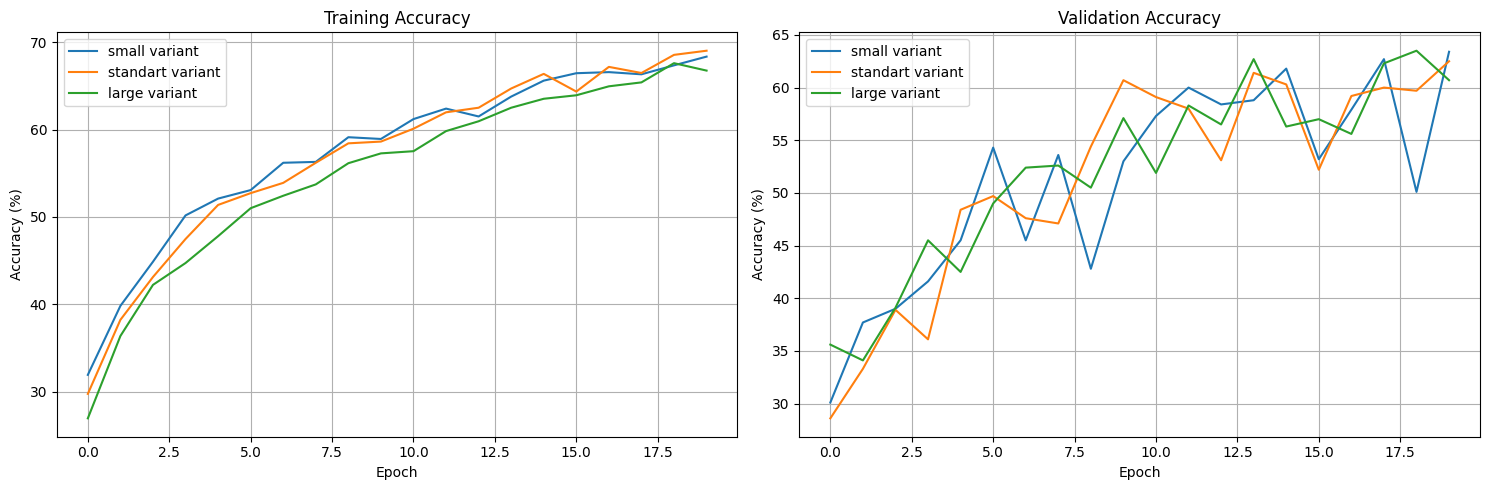

In [34]:
plot_acc([[history_small, "small variant"], [history_standart, "standart variant"], [history_large, "large variant"]])

In [36]:
total_params_small = sum(p.numel() for p in model_small.parameters())
trainable_params_small = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
print(f" Всего параметров варианта small: {total_params_small}")
print(f" Обучаемых параметров варианта small: {trainable_params_small}")

total_params_standart = sum(p.numel() for p in model_standart.parameters())
trainable_params_standart = sum(p.numel() for p in model_standart.parameters() if p.requires_grad)
print(f" Всего параметров варианта standart: {total_params_standart}")
print(f" Обучаемых параметров варианта standart: {trainable_params_standart}")

total_params_large = sum(p.numel() for p in model_large.parameters())
trainable_params_large = sum(p.numel() for p in model_large.parameters() if p.requires_grad)
print(f" Всего параметров варианта large: {total_params_large}")
print(f" Обучаемых параметров варианта large: {trainable_params_large}")

print(f"Лучшая acc для варината small: {best_val_acc_small}")
print(f"Лучшая acc для варината standart: {best_val_acc_standart}")
print(f"Лучшая acc для варината large: {best_val_acc_large}")

 Всего параметров варианта small: 1227978
 Обучаемых параметров варианта small: 1227978
 Всего параметров варианта standart: 2778058
 Обучаемых параметров варианта standart: 2778058
 Всего параметров варианта large: 4328138
 Обучаемых параметров варианта large: 4328138
Лучшая acc для варината small: 63.4
Лучшая acc для варината standart: 62.5
Лучшая acc для варината large: 63.5


Модели достигают лучших результатов на послених эпохах. В дальнейшем буду использовать small модель, хотя и у нее на валидации чуть хуже точноть, но параметров у нее почти в 4 раза меньше, что для моего случая критически важно, так как обучается долго на cpu

## 3.3. Эксперименты с функциями активации

In [43]:
class SimpleResNet18_Small_LeakyReLU(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1 = BasicBlock(64, 64)

        self.basic_block_2 = BasicBlock(64, 128, stride=2)

        self.basic_block_3 = BasicBlock(128, 256, stride=2)

        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1(x)
        x = self.basic_block_2(x)
        x = self.basic_block_3(x)

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x
    
class SimpleResNet18_Small_ELU(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1 = BasicBlock(64, 64)

        self.basic_block_2 = BasicBlock(64, 128, stride=2)

        self.basic_block_3 = BasicBlock(128, 256, stride=2)

        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1(x)
        x = self.basic_block_2(x)
        x = self.basic_block_3(x)

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x
    
class SimpleResNet18_Small_GELU(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.basic_block_1 = BasicBlock(64, 64)

        self.basic_block_2 = BasicBlock(64, 128, stride=2)

        self.basic_block_3 = BasicBlock(128, 256, stride=2)

        self.flatten = nn.Flatten()
        self.adapavgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.basic_block_1(x)
        x = self.basic_block_2(x)
        x = self.basic_block_3(x)

        x = self.fc(self.flatten(self.adapavgpool(x)))

        return x

In [38]:
model_LeakyReLU = SimpleResNet18_Small_LeakyReLU(num_classes=10)

history_LeakyReLU, model_LeakyReLU, best_val_acc_LeakyReLU = train_model(
    model=model_LeakyReLU, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_LeakyReLU.pth'
)

Параметры модели: 1,227,978
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.27it/s, loss=0.0317, acc=33.90%]



Эпоха 1 Вывод:
Training  |Loss: 0.0309 | Acc: 31.38%
Validation|Loss: 0.0317 | Acc: 33.90%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.39it/s, loss=0.0301, acc=33.50%]



Эпоха 2 Вывод:
Training  |Loss: 0.0272 | Acc: 40.40%
Validation|Loss: 0.0301 | Acc: 33.50%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.54it/s, loss=0.0284, acc=40.50%]



Эпоха 3 Вывод:
Training  |Loss: 0.0249 | Acc: 45.92%
Validation|Loss: 0.0284 | Acc: 40.50%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.25it/s, loss=0.0261, acc=45.20%]



Эпоха 4 Вывод:
Training  |Loss: 0.0236 | Acc: 48.98%
Validation|Loss: 0.0261 | Acc: 45.20%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.92it/s, loss=0.0241, acc=45.80%]



Эпоха 5 Вывод:
Training  |Loss: 0.0219 | Acc: 51.95%
Validation|Loss: 0.0241 | Acc: 45.80%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.04it/s, loss=0.0247, acc=46.80%]



Эпоха 6 Вывод:
Training  |Loss: 0.0210 | Acc: 53.45%
Validation|Loss: 0.0247 | Acc: 46.80%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.89it/s, loss=0.0235, acc=47.90%]



Эпоха 7 Вывод:
Training  |Loss: 0.0208 | Acc: 55.15%
Validation|Loss: 0.0235 | Acc: 47.90%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.26it/s, loss=0.0224, acc=55.40%]



Эпоха 8 Вывод:
Training  |Loss: 0.0199 | Acc: 56.50%
Validation|Loss: 0.0224 | Acc: 55.40%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.87it/s, loss=0.0195, acc=59.80%]



Эпоха 9 Вывод:
Training  |Loss: 0.0192 | Acc: 58.33%
Validation|Loss: 0.0195 | Acc: 59.80%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.39it/s, loss=0.0221, acc=53.90%]



Эпоха 10 Вывод:
Training  |Loss: 0.0184 | Acc: 60.25%
Validation|Loss: 0.0221 | Acc: 53.90%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.87it/s, loss=0.0218, acc=52.00%]



Эпоха 11 Вывод:
Training  |Loss: 0.0183 | Acc: 59.90%
Validation|Loss: 0.0218 | Acc: 52.00%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.81it/s, loss=0.0219, acc=50.30%]



Эпоха 12 Вывод:
Training  |Loss: 0.0177 | Acc: 61.80%
Validation|Loss: 0.0219 | Acc: 50.30%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.38it/s, loss=0.0199, acc=57.10%]



Эпоха 13 Вывод:
Training  |Loss: 0.0173 | Acc: 62.27%
Validation|Loss: 0.0199 | Acc: 57.10%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.52it/s, loss=0.0186, acc=61.20%]



Эпоха 14 Вывод:
Training  |Loss: 0.0166 | Acc: 63.70%
Validation|Loss: 0.0186 | Acc: 61.20%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.60it/s, loss=0.0177, acc=64.40%]



Эпоха 15 Вывод:
Training  |Loss: 0.0160 | Acc: 65.70%
Validation|Loss: 0.0177 | Acc: 64.40%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.53it/s, loss=0.0212, acc=55.30%]



Эпоха 16 Вывод:
Training  |Loss: 0.0159 | Acc: 64.67%
Validation|Loss: 0.0212 | Acc: 55.30%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.47it/s, loss=0.0181, acc=61.30%]



Эпоха 17 Вывод:
Training  |Loss: 0.0154 | Acc: 67.50%
Validation|Loss: 0.0181 | Acc: 61.30%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.50it/s, loss=0.0192, acc=58.70%]



Эпоха 18 Вывод:
Training  |Loss: 0.0151 | Acc: 67.17%
Validation|Loss: 0.0192 | Acc: 58.70%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.33it/s, loss=0.0176, acc=64.00%]



Эпоха 19 Вывод:
Training  |Loss: 0.0148 | Acc: 68.53%
Validation|Loss: 0.0176 | Acc: 64.00%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.24it/s, loss=0.0175, acc=64.80%]


Эпоха 20 Вывод:
Training  |Loss: 0.0143 | Acc: 68.60%
Validation|Loss: 0.0175 | Acc: 64.80%
Все!
Лучшая acc на валидации   : 64.80% это на эпохе 20
Финальная acc на трейне   : 68.60%
Финальная acc на валидации: 64.80%


In [41]:
model_ELU = SimpleResNet18_Small_ELU(num_classes=10)

history_ELU, model_ELU, best_val_acc_ELU = train_model(
    model=model_ELU, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_ELU.pth'
)

Параметры модели: 1,227,978
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.19it/s, loss=0.0292, acc=35.80%]



Эпоха 1 Вывод:
Training  |Loss: 0.0302 | Acc: 33.17%
Validation|Loss: 0.0292 | Acc: 35.80%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.80it/s, loss=0.0282, acc=38.00%]



Эпоха 2 Вывод:
Training  |Loss: 0.0273 | Acc: 41.00%
Validation|Loss: 0.0282 | Acc: 38.00%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.47it/s, loss=0.0255, acc=47.50%]



Эпоха 3 Вывод:
Training  |Loss: 0.0249 | Acc: 45.27%
Validation|Loss: 0.0255 | Acc: 47.50%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.33it/s, loss=0.0239, acc=48.70%]



Эпоха 4 Вывод:
Training  |Loss: 0.0231 | Acc: 50.60%
Validation|Loss: 0.0239 | Acc: 48.70%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.89it/s, loss=0.0225, acc=52.60%]



Эпоха 5 Вывод:
Training  |Loss: 0.0219 | Acc: 52.00%
Validation|Loss: 0.0225 | Acc: 52.60%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.53it/s, loss=0.0212, acc=55.60%]



Эпоха 6 Вывод:
Training  |Loss: 0.0209 | Acc: 54.02%
Validation|Loss: 0.0212 | Acc: 55.60%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.20it/s, loss=0.0209, acc=54.60%]



Эпоха 7 Вывод:
Training  |Loss: 0.0201 | Acc: 55.85%
Validation|Loss: 0.0209 | Acc: 54.60%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.46it/s, loss=0.0227, acc=51.50%]



Эпоха 8 Вывод:
Training  |Loss: 0.0193 | Acc: 57.92%
Validation|Loss: 0.0227 | Acc: 51.50%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.81it/s, loss=0.0213, acc=53.60%]



Эпоха 9 Вывод:
Training  |Loss: 0.0188 | Acc: 59.38%
Validation|Loss: 0.0213 | Acc: 53.60%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.51it/s, loss=0.0194, acc=59.40%]



Эпоха 10 Вывод:
Training  |Loss: 0.0180 | Acc: 60.95%
Validation|Loss: 0.0194 | Acc: 59.40%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.60it/s, loss=0.0234, acc=48.60%]



Эпоха 11 Вывод:
Training  |Loss: 0.0176 | Acc: 61.27%
Validation|Loss: 0.0234 | Acc: 48.60%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=0.0208, acc=53.30%]



Эпоха 12 Вывод:
Training  |Loss: 0.0172 | Acc: 62.62%
Validation|Loss: 0.0208 | Acc: 53.30%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0205, acc=55.80%]



Эпоха 13 Вывод:
Training  |Loss: 0.0171 | Acc: 62.73%
Validation|Loss: 0.0205 | Acc: 55.80%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.92it/s, loss=0.0197, acc=59.30%]



Эпоха 14 Вывод:
Training  |Loss: 0.0166 | Acc: 63.95%
Validation|Loss: 0.0197 | Acc: 59.30%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.25it/s, loss=0.0182, acc=61.00%]



Эпоха 15 Вывод:
Training  |Loss: 0.0156 | Acc: 66.42%
Validation|Loss: 0.0182 | Acc: 61.00%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.01it/s, loss=0.0213, acc=59.70%]



Эпоха 16 Вывод:
Training  |Loss: 0.0154 | Acc: 65.85%
Validation|Loss: 0.0213 | Acc: 59.70%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.86it/s, loss=0.0173, acc=63.40%]



Эпоха 17 Вывод:
Training  |Loss: 0.0151 | Acc: 67.53%
Validation|Loss: 0.0173 | Acc: 63.40%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.26it/s, loss=0.0168, acc=64.70%]



Эпоха 18 Вывод:
Training  |Loss: 0.0147 | Acc: 67.25%
Validation|Loss: 0.0168 | Acc: 64.70%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.53it/s, loss=0.0256, acc=51.90%]



Эпоха 19 Вывод:
Training  |Loss: 0.0147 | Acc: 67.62%
Validation|Loss: 0.0256 | Acc: 51.90%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.21it/s, loss=0.0180, acc=65.60%]


Эпоха 20 Вывод:
Training  |Loss: 0.0138 | Acc: 70.12%
Validation|Loss: 0.0180 | Acc: 65.60%
Все!
Лучшая acc на валидации   : 65.60% это на эпохе 20
Финальная acc на трейне   : 70.12%
Финальная acc на валидации: 65.60%


In [44]:
model_GELU = SimpleResNet18_Small_GELU(num_classes=10)

history_GELU, model_GELU, best_val_acc_GELU = train_model(
    model=model_GELU, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=20, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_GELU.pth'
)

Параметры модели: 1,227,978
Optimizer: Adam, lr: 0.001

Эпоха 1 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.72it/s, loss=0.0291, acc=38.00%]



Эпоха 1 Вывод:
Training  |Loss: 0.0306 | Acc: 31.55%
Validation|Loss: 0.0291 | Acc: 38.00%

Эпоха 2 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.81it/s, loss=0.0284, acc=42.00%]



Эпоха 2 Вывод:
Training  |Loss: 0.0272 | Acc: 39.77%
Validation|Loss: 0.0284 | Acc: 42.00%

Эпоха 3 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.03it/s, loss=0.0249, acc=44.60%]



Эпоха 3 Вывод:
Training  |Loss: 0.0256 | Acc: 44.08%
Validation|Loss: 0.0249 | Acc: 44.60%

Эпоха 4 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.33it/s, loss=0.0235, acc=49.50%]



Эпоха 4 Вывод:
Training  |Loss: 0.0232 | Acc: 50.95%
Validation|Loss: 0.0235 | Acc: 49.50%

Эпоха 5 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.54it/s, loss=0.0217, acc=53.70%]



Эпоха 5 Вывод:
Training  |Loss: 0.0223 | Acc: 51.27%
Validation|Loss: 0.0217 | Acc: 53.70%

Эпоха 6 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.52it/s, loss=0.0289, acc=41.60%]



Эпоха 6 Вывод:
Training  |Loss: 0.0213 | Acc: 53.27%
Validation|Loss: 0.0289 | Acc: 41.60%

Эпоха 7 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.47it/s, loss=0.0221, acc=52.50%]



Эпоха 7 Вывод:
Training  |Loss: 0.0206 | Acc: 55.10%
Validation|Loss: 0.0221 | Acc: 52.50%

Эпоха 8 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.23it/s, loss=0.0199, acc=58.20%]



Эпоха 8 Вывод:
Training  |Loss: 0.0194 | Acc: 57.90%
Validation|Loss: 0.0199 | Acc: 58.20%

Эпоха 9 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.15it/s, loss=0.0227, acc=52.90%]



Эпоха 9 Вывод:
Training  |Loss: 0.0193 | Acc: 57.92%
Validation|Loss: 0.0227 | Acc: 52.90%

Эпоха 10 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.21it/s, loss=0.0222, acc=55.40%]



Эпоха 10 Вывод:
Training  |Loss: 0.0183 | Acc: 60.35%
Validation|Loss: 0.0222 | Acc: 55.40%

Эпоха 11 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.06it/s, loss=0.0197, acc=59.40%]



Эпоха 11 Вывод:
Training  |Loss: 0.0180 | Acc: 61.05%
Validation|Loss: 0.0197 | Acc: 59.40%

Эпоха 12 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.83it/s, loss=0.0229, acc=53.20%]



Эпоха 12 Вывод:
Training  |Loss: 0.0175 | Acc: 61.65%
Validation|Loss: 0.0229 | Acc: 53.20%

Эпоха 13 из 20


Валидация  : 100%|██████████| 16/16 [00:03<00:00,  5.13it/s, loss=0.0204, acc=57.90%]



Эпоха 13 Вывод:
Training  |Loss: 0.0168 | Acc: 62.70%
Validation|Loss: 0.0204 | Acc: 57.90%

Эпоха 14 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.01it/s, loss=0.0179, acc=62.20%]



Эпоха 14 Вывод:
Training  |Loss: 0.0162 | Acc: 64.42%
Validation|Loss: 0.0179 | Acc: 62.20%

Эпоха 15 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.60it/s, loss=0.0186, acc=60.70%]



Эпоха 15 Вывод:
Training  |Loss: 0.0161 | Acc: 65.03%
Validation|Loss: 0.0186 | Acc: 60.70%

Эпоха 16 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.18it/s, loss=0.0178, acc=62.80%]



Эпоха 16 Вывод:
Training  |Loss: 0.0161 | Acc: 65.25%
Validation|Loss: 0.0178 | Acc: 62.80%

Эпоха 17 из 20


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.01it/s, loss=0.0178, acc=62.10%]



Эпоха 17 Вывод:
Training  |Loss: 0.0150 | Acc: 67.47%
Validation|Loss: 0.0178 | Acc: 62.10%

Эпоха 18 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.85it/s, loss=0.0258, acc=48.80%]



Эпоха 18 Вывод:
Training  |Loss: 0.0147 | Acc: 66.72%
Validation|Loss: 0.0258 | Acc: 48.80%

Эпоха 19 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.84it/s, loss=0.0167, acc=64.30%]



Эпоха 19 Вывод:
Training  |Loss: 0.0146 | Acc: 68.12%
Validation|Loss: 0.0167 | Acc: 64.30%

Эпоха 20 из 20


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.59it/s, loss=0.0173, acc=63.20%]


Эпоха 20 Вывод:
Training  |Loss: 0.0146 | Acc: 67.65%
Validation|Loss: 0.0173 | Acc: 63.20%
Все!
Лучшая acc на валидации   : 64.30% это на эпохе 19
Финальная acc на трейне   : 67.65%
Финальная acc на валидации: 63.20%


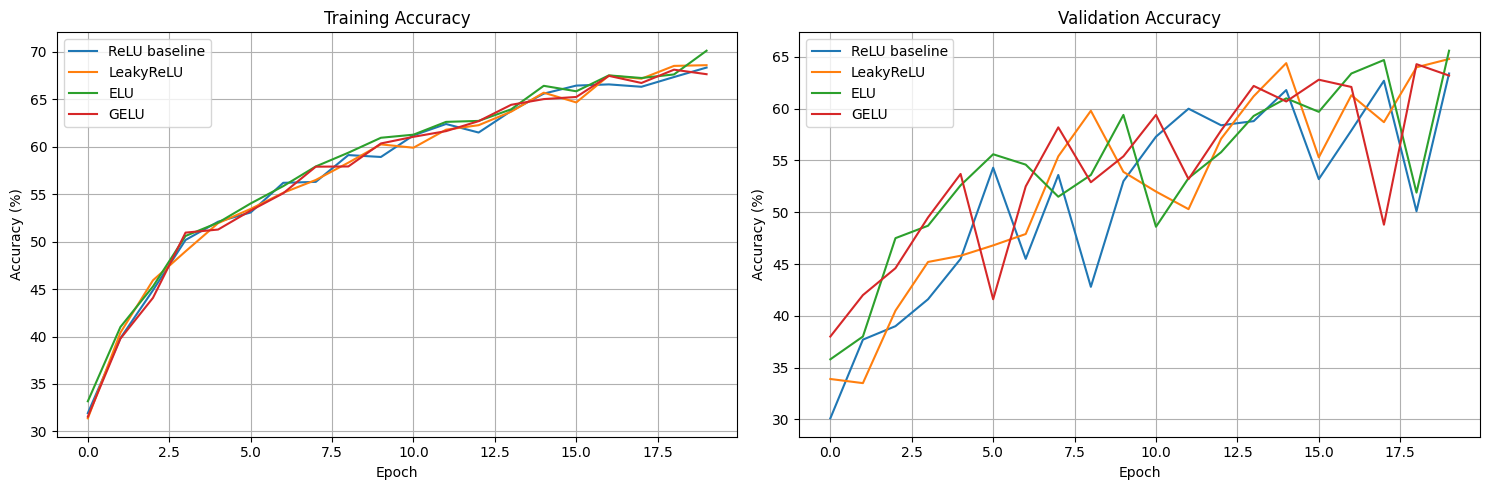

In [45]:
plot_acc([[history_small, "ReLU baseline"], [history_LeakyReLU, "LeakyReLU"], [history_ELU, "ELU"], [history_GELU, "GELU"]])

In [46]:
total_params_small = sum(p.numel() for p in model_small.parameters())
trainable_params_small = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
print(f" Всего параметров варианта baseline ReLU: {total_params_small}")
print(f" Обучаемых параметров варианта baseline ReLU: {trainable_params_small}")

total_params_LeakyReLU = sum(p.numel() for p in model_LeakyReLU.parameters())
trainable_params_LeakyReLU = sum(p.numel() for p in model_LeakyReLU.parameters() if p.requires_grad)
print(f" Всего параметров варианта LeakyReLU: {total_params_LeakyReLU}")
print(f" Обучаемых параметров варианта LeakyReLU: {trainable_params_LeakyReLU}")

total_params_ELU = sum(p.numel() for p in model_ELU.parameters())
trainable_params_ELU = sum(p.numel() for p in model_ELU.parameters() if p.requires_grad)
print(f" Всего параметров варианта ELU: {total_params_ELU}")
print(f" Обучаемых параметров варианта ELU: {trainable_params_ELU}")

total_params_GELU = sum(p.numel() for p in model_GELU.parameters())
trainable_params_GELU = sum(p.numel() for p in model_GELU.parameters() if p.requires_grad)
print(f" Всего параметров варианта GELU: {total_params_GELU}")
print(f" Обучаемых параметров варианта GELU: {trainable_params_GELU}")

print(f"Лучшая acc для варината baseline ReLU: {best_val_acc_small}")
print(f"Лучшая acc для варината LeakyReLU: {best_val_acc_LeakyReLU}")
print(f"Лучшая acc для варината ELU: {best_val_acc_ELU}")
print(f"Лучшая acc для варината GELU: {best_val_acc_GELU}")

 Всего параметров варианта baseline ReLU: 1227978
 Обучаемых параметров варианта baseline ReLU: 1227978
 Всего параметров варианта LeakyReLU: 1227978
 Обучаемых параметров варианта LeakyReLU: 1227978
 Всего параметров варианта ELU: 1227978
 Обучаемых параметров варианта ELU: 1227978
 Всего параметров варианта GELU: 1227978
 Обучаемых параметров варианта GELU: 1227978
Лучшая acc для варината baseline ReLU: 63.4
Лучшая acc для варината LeakyReLU: 64.8
Лучшая acc для варината ELU: 65.6
Лучшая acc для варината GELU: 64.3


Далее будет использоваться ELU, поскольку она точнее всех на валидации

# Часть 4. Финальная модель

## 4.1. Создание финальной модели

In [47]:
model_final = SimpleResNet18_Small_ELU(10)

history_final, model_final, best_val_acc_final = train_model(
    model=model_final, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=40, 
    learning_rate=0.001, 
    optimizer_type='adam', 
    device=device,
    save_file_name='best_model_final.pth'
)

Параметры модели: 1,227,978
Optimizer: Adam, lr: 0.001

Эпоха 1 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.27it/s, loss=0.0284, acc=37.60%]



Эпоха 1 Вывод:
Training  |Loss: 0.0306 | Acc: 31.57%
Validation|Loss: 0.0284 | Acc: 37.60%

Эпоха 2 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.84it/s, loss=0.0359, acc=33.70%]



Эпоха 2 Вывод:
Training  |Loss: 0.0274 | Acc: 39.85%
Validation|Loss: 0.0359 | Acc: 33.70%

Эпоха 3 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.40it/s, loss=0.0324, acc=35.90%]



Эпоха 3 Вывод:
Training  |Loss: 0.0249 | Acc: 45.80%
Validation|Loss: 0.0324 | Acc: 35.90%

Эпоха 4 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.42it/s, loss=0.0266, acc=45.60%]



Эпоха 4 Вывод:
Training  |Loss: 0.0234 | Acc: 49.70%
Validation|Loss: 0.0266 | Acc: 45.60%

Эпоха 5 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.57it/s, loss=0.0224, acc=51.90%]



Эпоха 5 Вывод:
Training  |Loss: 0.0224 | Acc: 51.55%
Validation|Loss: 0.0224 | Acc: 51.90%

Эпоха 6 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.56it/s, loss=0.0268, acc=44.80%]



Эпоха 6 Вывод:
Training  |Loss: 0.0210 | Acc: 54.42%
Validation|Loss: 0.0268 | Acc: 44.80%

Эпоха 7 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.07it/s, loss=0.0259, acc=46.60%]



Эпоха 7 Вывод:
Training  |Loss: 0.0205 | Acc: 55.90%
Validation|Loss: 0.0259 | Acc: 46.60%

Эпоха 8 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.88it/s, loss=0.0271, acc=47.20%]



Эпоха 8 Вывод:
Training  |Loss: 0.0197 | Acc: 57.27%
Validation|Loss: 0.0271 | Acc: 47.20%

Эпоха 9 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.19it/s, loss=0.0222, acc=52.30%]



Эпоха 9 Вывод:
Training  |Loss: 0.0193 | Acc: 57.10%
Validation|Loss: 0.0222 | Acc: 52.30%

Эпоха 10 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=0.0232, acc=50.80%]



Эпоха 10 Вывод:
Training  |Loss: 0.0182 | Acc: 59.85%
Validation|Loss: 0.0232 | Acc: 50.80%

Эпоха 11 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.46it/s, loss=0.0200, acc=57.50%]



Эпоха 11 Вывод:
Training  |Loss: 0.0180 | Acc: 60.73%
Validation|Loss: 0.0200 | Acc: 57.50%

Эпоха 12 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.36it/s, loss=0.0191, acc=60.30%]



Эпоха 12 Вывод:
Training  |Loss: 0.0174 | Acc: 61.48%
Validation|Loss: 0.0191 | Acc: 60.30%

Эпоха 13 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.97it/s, loss=0.0213, acc=55.80%]



Эпоха 13 Вывод:
Training  |Loss: 0.0173 | Acc: 62.85%
Validation|Loss: 0.0213 | Acc: 55.80%

Эпоха 14 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.92it/s, loss=0.0190, acc=59.70%]



Эпоха 14 Вывод:
Training  |Loss: 0.0164 | Acc: 64.03%
Validation|Loss: 0.0190 | Acc: 59.70%

Эпоха 15 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.54it/s, loss=0.0187, acc=60.20%]



Эпоха 15 Вывод:
Training  |Loss: 0.0160 | Acc: 65.10%
Validation|Loss: 0.0187 | Acc: 60.20%

Эпоха 16 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.39it/s, loss=0.0182, acc=63.00%]



Эпоха 16 Вывод:
Training  |Loss: 0.0159 | Acc: 64.95%
Validation|Loss: 0.0182 | Acc: 63.00%

Эпоха 17 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.63it/s, loss=0.0200, acc=59.80%]



Эпоха 17 Вывод:
Training  |Loss: 0.0154 | Acc: 66.85%
Validation|Loss: 0.0200 | Acc: 59.80%

Эпоха 18 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.47it/s, loss=0.0259, acc=49.70%]



Эпоха 18 Вывод:
Training  |Loss: 0.0148 | Acc: 68.78%
Validation|Loss: 0.0259 | Acc: 49.70%

Эпоха 19 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.45it/s, loss=0.0226, acc=56.50%]



Эпоха 19 Вывод:
Training  |Loss: 0.0146 | Acc: 68.17%
Validation|Loss: 0.0226 | Acc: 56.50%

Эпоха 20 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.80it/s, loss=0.0221, acc=54.00%]



Эпоха 20 Вывод:
Training  |Loss: 0.0142 | Acc: 70.03%
Validation|Loss: 0.0221 | Acc: 54.00%

Эпоха 21 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.59it/s, loss=0.0164, acc=66.50%]



Эпоха 21 Вывод:
Training  |Loss: 0.0142 | Acc: 69.10%
Validation|Loss: 0.0164 | Acc: 66.50%

Эпоха 22 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  6.86it/s, loss=0.0267, acc=50.90%]



Эпоха 22 Вывод:
Training  |Loss: 0.0135 | Acc: 71.17%
Validation|Loss: 0.0267 | Acc: 50.90%

Эпоха 23 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.88it/s, loss=0.0179, acc=65.10%]



Эпоха 23 Вывод:
Training  |Loss: 0.0138 | Acc: 69.85%
Validation|Loss: 0.0179 | Acc: 65.10%

Эпоха 24 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.84it/s, loss=0.0224, acc=55.00%]



Эпоха 24 Вывод:
Training  |Loss: 0.0131 | Acc: 71.95%
Validation|Loss: 0.0224 | Acc: 55.00%

Эпоха 25 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, loss=0.0179, acc=64.70%]



Эпоха 25 Вывод:
Training  |Loss: 0.0129 | Acc: 72.10%
Validation|Loss: 0.0179 | Acc: 64.70%

Эпоха 26 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.66it/s, loss=0.0160, acc=66.90%]



Эпоха 26 Вывод:
Training  |Loss: 0.0124 | Acc: 74.15%
Validation|Loss: 0.0160 | Acc: 66.90%

Эпоха 27 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.74it/s, loss=0.0164, acc=65.10%]



Эпоха 27 Вывод:
Training  |Loss: 0.0123 | Acc: 72.60%
Validation|Loss: 0.0164 | Acc: 65.10%

Эпоха 28 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.67it/s, loss=0.0175, acc=65.80%]



Эпоха 28 Вывод:
Training  |Loss: 0.0118 | Acc: 75.15%
Validation|Loss: 0.0175 | Acc: 65.80%

Эпоха 29 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.40it/s, loss=0.0159, acc=67.50%]



Эпоха 29 Вывод:
Training  |Loss: 0.0114 | Acc: 75.40%
Validation|Loss: 0.0159 | Acc: 67.50%

Эпоха 30 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.51it/s, loss=0.0178, acc=65.20%]



Эпоха 30 Вывод:
Training  |Loss: 0.0115 | Acc: 74.50%
Validation|Loss: 0.0178 | Acc: 65.20%

Эпоха 31 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.91it/s, loss=0.0187, acc=63.60%]



Эпоха 31 Вывод:
Training  |Loss: 0.0112 | Acc: 75.15%
Validation|Loss: 0.0187 | Acc: 63.60%

Эпоха 32 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.78it/s, loss=0.0153, acc=68.80%]



Эпоха 32 Вывод:
Training  |Loss: 0.0110 | Acc: 76.12%
Validation|Loss: 0.0153 | Acc: 68.80%

Эпоха 33 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.69it/s, loss=0.0156, acc=68.40%]



Эпоха 33 Вывод:
Training  |Loss: 0.0107 | Acc: 76.90%
Validation|Loss: 0.0156 | Acc: 68.40%

Эпоха 34 из 40


Валидация  : 100%|██████████| 16/16 [00:01<00:00,  8.38it/s, loss=0.0212, acc=60.50%]



Эпоха 34 Вывод:
Training  |Loss: 0.0106 | Acc: 76.70%
Validation|Loss: 0.0212 | Acc: 60.50%

Эпоха 35 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.28it/s, loss=0.0160, acc=67.60%]



Эпоха 35 Вывод:
Training  |Loss: 0.0100 | Acc: 78.72%
Validation|Loss: 0.0160 | Acc: 67.60%

Эпоха 36 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.28it/s, loss=0.0171, acc=68.20%]



Эпоха 36 Вывод:
Training  |Loss: 0.0098 | Acc: 78.20%
Validation|Loss: 0.0171 | Acc: 68.20%

Эпоха 37 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.76it/s, loss=0.0153, acc=70.80%]



Эпоха 37 Вывод:
Training  |Loss: 0.0095 | Acc: 79.75%
Validation|Loss: 0.0153 | Acc: 70.80%

Эпоха 38 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.04it/s, loss=0.0166, acc=67.70%]



Эпоха 38 Вывод:
Training  |Loss: 0.0089 | Acc: 80.88%
Validation|Loss: 0.0166 | Acc: 67.70%

Эпоха 39 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.83it/s, loss=0.0164, acc=69.00%]



Эпоха 39 Вывод:
Training  |Loss: 0.0092 | Acc: 80.22%
Validation|Loss: 0.0164 | Acc: 69.00%

Эпоха 40 из 40


Валидация  : 100%|██████████| 16/16 [00:02<00:00,  7.90it/s, loss=0.0156, acc=70.00%]


Эпоха 40 Вывод:
Training  |Loss: 0.0092 | Acc: 79.53%
Validation|Loss: 0.0156 | Acc: 70.00%
Все!
Лучшая acc на валидации   : 70.80% это на эпохе 37
Финальная acc на трейне   : 79.53%
Финальная acc на валидации: 70.00%


ИНФОРМАЦИЯ О МОДЕЛИ И РЕЗУЛЬТАТЫ ОБУЧЕНИЯ

1. АРХИТЕКТУРА МОДЕЛИ:
------------------------------
SimpleResNet18_Small_ELU(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ELU(alpha=1.0, inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (basic_block_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Identity()
  )
  (basic_block_2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bia

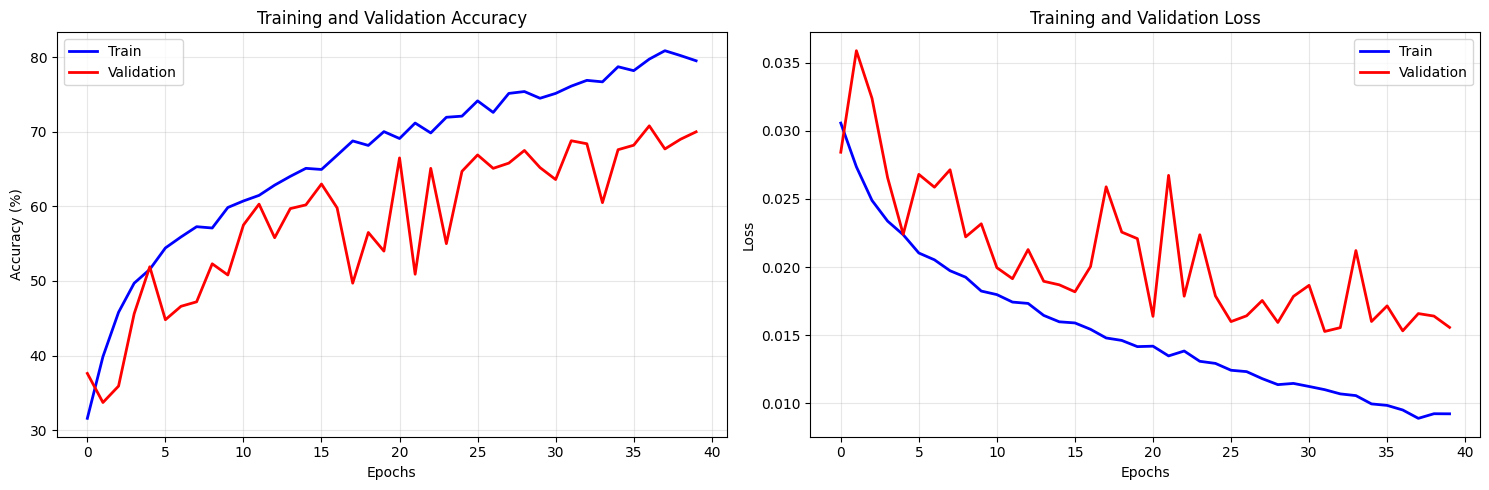

In [52]:
print_model_summary_and_plot(history_final, model_final)

In [73]:
total_params_final = sum(p.numel() for p in model_final.parameters())
trainable_params_final = sum(p.numel() for p in model_final.parameters() if p.requires_grad)
print(f" Всего параметров варианта final: {total_params_final}")
print(f" Обучаемых параметров варианта final: {trainable_params_final}")

print(f"Лучшая acc для варината final: {best_val_acc_final}")

 Всего параметров варианта final: 1227978
 Обучаемых параметров варианта final: 1227978
Лучшая acc для варината final: 70.8


## 4.2. Тестирование на test set

test_dataset создавали на этапе запуска скрипта, поэтому тут он берется как уже известная переменная

In [65]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

def evaluate_on_test_set(model, test_loader, device='cpu', class_names=None):
    """
    Оценка модели на test set
    
    Args:
        model: модель для тестирования
        test_loader: DataLoader с тестовыми данными
        device: устройство для вычислений
        class_names: список названий классов (если None, используются индексы)
    
    Returns:
        metrics: словарь с метриками
        all_preds: все предсказания
        all_labels: все истинные метки
    """
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    print("Тестирование на test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Тестирование"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Конвертируем в numpy массивы
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Вычисляем метрики
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    # Результаты
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ НА TEST SET")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print("\nМетрики по классам:")
    print("-"*60)
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(precision))]
    
    for i in range(len(precision)):
        print(f"{class_names[i]:40} | Precision: {precision[i]:.4f} | "
              f"Recall: {recall[i]:.4f} | F1: {f1[i]:.4f} | Support: {support[i]}")
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'all_preds': all_preds,
        'all_labels': all_labels
    }
    
    return metrics, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    """
    Визуализация confusion matrix
    
    Args:
        all_labels: истинные метки
        all_preds: предсказанные метки
        class_names: список названий классов
    """
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.tight_layout()
    plt.show()
    
    # Выводим наиболее частые ошибки
    print("\nНаиболее частые ошибки:")
    errors = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                errors.append((i, j, cm[i, j]))
    
    # Сортируем по количеству ошибок
    errors.sort(key=lambda x: x[2], reverse=True)
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]
    
    for i, j, count in errors[:10]:  # Топ-10 ошибок
        print(f"{class_names[i]} → {class_names[j]}: {count} ошибок")

# Основная функция для выполнения всех заданий
def test_and_analyze_model(model_path, model_class, test_loader, test_dataset, device='cpu', class_names=None):
    """
    Полный пайплайн тестирования и анализа
    
    Args:
        model_path: путь к сохраненной модели
        model_class: класс модели (например SimpleResNet18_Small_ELU)
        test_loader: DataLoader с тестовыми данными
        test_dataset: тестовый датасет
        device: устройство
        class_names: названия классов
    """
    print("="*60)
    print("ТЕСТИРОВАНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
    print("="*60)
    
    # 1. Загрузка модели
    print("1. Загрузка лучшей модели...")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Создаем модель
    model = model_class(num_classes=10)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"Модель загружена из эпохи {checkpoint['epoch']}")
    print(f"Validation accuracy при сохранении: {checkpoint['val_acc']:.2f}%")
    
    # 2. Оценка на test set
    print("\n2. Оценка на test set...")
    metrics, all_preds, all_labels = evaluate_on_test_set(
        model=model,
        test_loader=test_loader,
        device=device,
        class_names=class_names
    )
    
    # 3. Confusion Matrix
    print("\n3. Confusion Matrix...")
    plot_confusion_matrix(all_labels, all_preds, class_names=class_names)

    
    return metrics, model

# Находим имена всех классов
def load__labels(words_path="data/tiny-imagenet-200/words.txt"):
    labels = {}
    with open(words_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                wnid = parts[0]
                desc = parts[1]
                labels[wnid] = desc
    return labels

1. Загрузка лучшей модели...
Модель загружена из эпохи 37
Validation accuracy при сохранении: 70.80%

2. Оценка на test set...
Тестирование на test set...


Тестирование: 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]



РЕЗУЛЬТАТЫ НА TEST SET
Accuracy: 0.6640 (66.40%)
Macro Precision: 0.6738
Macro Recall: 0.6640
Macro F1-score: 0.6579

Метрики по классам:
------------------------------------------------------------
Egyptian cat                             | Precision: 0.7838 | Recall: 0.5800 | F1: 0.6667 | Support: 50
reel                                     | Precision: 0.5357 | Recall: 0.3000 | F1: 0.3846 | Support: 50
volleyball                               | Precision: 0.6522 | Recall: 0.6000 | F1: 0.6250 | Support: 50
rocking chair, rocker                    | Precision: 0.5467 | Recall: 0.8200 | F1: 0.6560 | Support: 50
lemon                                    | Precision: 0.8409 | Recall: 0.7400 | F1: 0.7872 | Support: 50
bullfrog, Rana catesbeiana               | Precision: 0.6667 | Recall: 0.8400 | F1: 0.7434 | Support: 50
basketball                               | Precision: 0.5439 | Recall: 0.6200 | F1: 0.5794 | Support: 50
cliff, drop, drop-off                    | Precision: 0.7097 | Re

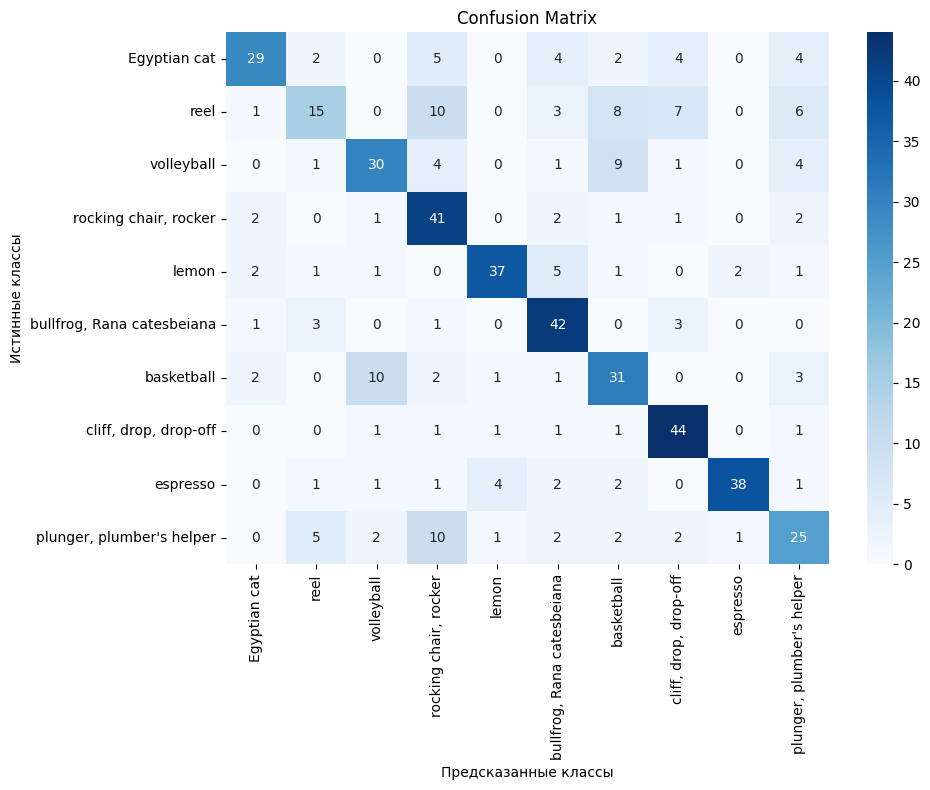


Наиболее частые ошибки:
reel → rocking chair, rocker: 10 ошибок
basketball → volleyball: 10 ошибок
plunger, plumber's helper → rocking chair, rocker: 10 ошибок
volleyball → basketball: 9 ошибок
reel → basketball: 8 ошибок
reel → cliff, drop, drop-off: 7 ошибок
reel → plunger, plumber's helper: 6 ошибок
Egyptian cat → rocking chair, rocker: 5 ошибок
lemon → bullfrog, Rana catesbeiana: 5 ошибок
plunger, plumber's helper → reel: 5 ошибок


In [66]:
# Получаем имена классов (можно орагинозовать, но пока лень, если получится найти быстро, можно потом добавить)
class_names_all = load__labels()
class_names = [class_names_all[val_dataset_big.class_names[i]] for i in selected_classes] 


test_dataset = CustomDataset(test_subset_samples, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print("1. Загрузка лучшей модели...")
checkpoint = torch.load('best_model_final.pth', map_location=device)

# Создаем модель
model = SimpleResNet18_Small_ELU(num_classes=10)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

print(f"Модель загружена из эпохи {checkpoint['epoch']}")
print(f"Validation accuracy при сохранении: {checkpoint['val_acc']:.2f}%")

# Оценка на test set
print("\n2. Оценка на test set...")
metrics, all_preds, all_labels = evaluate_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=class_names
)

# Confusion Matrix
print("\n3. Confusion Matrix...")
plot_confusion_matrix(all_labels, all_preds, class_names=class_names)

## 4.3. Визуальный анализ



4. Визуальный анализ...
Визуальный анализ предсказаний:
------------------------------------------------------------
+ Пример 1: Истинный: basketball                     | Предсказание: basketball
+ Пример 2: Истинный: plunger, plumber's helper      | Предсказание: plunger, plumber's helper
+ Пример 3: Истинный: Egyptian cat                   | Предсказание: Egyptian cat
- Пример 4: Истинный: basketball                     | Предсказание: volleyball
+ Пример 5: Истинный: lemon                          | Предсказание: lemon
- Пример 6: Истинный: basketball                     | Предсказание: rocking chair, rocker
+ Пример 7: Истинный: volleyball                     | Предсказание: volleyball
+ Пример 8: Истинный: bullfrog, Rana catesbeiana     | Предсказание: bullfrog, Rana catesbeiana
+ Пример 9: Истинный: plunger, plumber's helper      | Предсказание: plunger, plumber's helper
- Пример 10: Истинный: volleyball                     | Предсказание: rocking chair, rocker


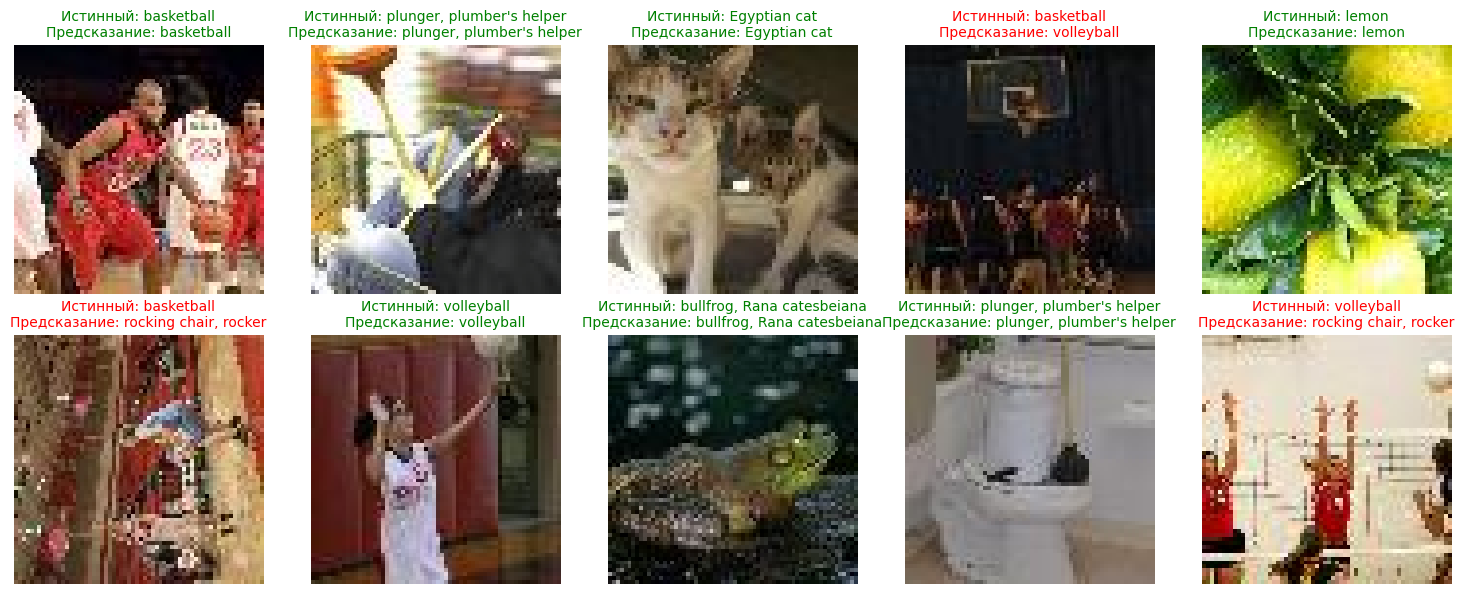

In [70]:
def visualize_predictions(model, dataset, num_samples=10, device='cpu', class_names=None):
    """
    Визуализация случайных предсказаний
    
    Args:
        model: модель для предсказаний
        dataset: тестовый датасет
        num_samples: количество примеров для визуализации
        device: устройство для вычислений
        class_names: список названий классов
    """
    model.eval()
    model.to(device)
    
    if class_names is None:
        class_names = train_dataset.class_names if hasattr(train_dataset, 'class_names') else [f"Class {i}" for i in range(10)]
    
    # Выбираем случайные индексы
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    print("Визуальный анализ предсказаний:")
    print("-"*60)
    
    for idx, ax_idx in zip(indices, range(num_samples)):
        image, true_label = dataset[idx]
        
        # Предсказание
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            _, pred = torch.max(output, 1)
            pred_label = pred.item()
        
        # Денормализация для отображения
        def denormalize(tensor):
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
            tensor = tensor.permute(1, 2, 0) * std + mean
            return tensor.clamp(0, 1)
        
        # Визуализация
        img_display = denormalize(image)
        ax = axes[ax_idx]
        ax.imshow(img_display)
        
        # Цвет текста (зеленый если правильно, красный если ошибка)
        color = 'green' if true_label == pred_label else 'red'
        
        true_class = class_names[true_label] if true_label < len(class_names) else f"Class {true_label}"
        pred_class = class_names[pred_label] if pred_label < len(class_names) else f"Class {pred_label}"
        
        ax.set_title(f"Истинный: {true_class}\nПредсказание: {pred_class}", 
                    color=color, fontsize=10)
        ax.axis('off')
        
        # Вывод в консоль
        correct = "+" if true_label == pred_label else "-"
        print(f"{correct} Пример {ax_idx+1}: Истинный: {true_class:30} | Предсказание: {pred_class}")
    
    plt.tight_layout()
    plt.show()
    

# Визуальный анализ
print("\n4. Визуальный анализ...")
visualize_predictions(
    model=model,
    dataset=test_dataset,
    num_samples=10,
    device=device,
    class_names=class_names
)

## 4.4. Сравнительная таблица всех экспериментов

In [76]:
results = [
    {"Этап": "Baseline", "Конфигурация": "Базовая модель", "Параметры": trainable_params_B, "Val Accuracy": best_val_acc_B, "Train Accuracy": 0.676},
    {"Этап": "3.1-A", "Конфигурация": "32→64→128→256", "Параметры": trainable_params_A, "Val Accuracy":  best_val_acc_A, "Train Accuracy": 0.698},
    {"Этап": "3.1-B", "Конфигурация": "64→128→256", "Параметры": trainable_params_B, "Val Accuracy": best_val_acc_B, "Train Accuracy": 0.676},
    {"Этап": "3.2-A", "Конфигурация": "[1,1,1,1] блоков", "Параметры": trainable_params_small, "Val Accuracy": best_val_acc_small, "Train Accuracy": 0.684},
    {"Этап": "3.2-B", "Конфигурация": "[2,2,2,2] блоков", "Параметры": trainable_params_standart, "Val Accuracy": best_val_acc_standart, "Train Accuracy": 0.69},
    {"Этап": "3.2-C", "Конфигурация": "[3,3,3,3] блоков", "Параметры": trainable_params_large, "Val Accuracy": best_val_acc_large, "Train Accuracy": 0.67},
    {"Этап": "3.3-A", "Конфигурация": "ReLU", "Параметры": trainable_params_small, "Val Accuracy": best_val_acc_small, "Train Accuracy": 0.684},
    {"Этап": "3.3-B", "Конфигурация": "LeakyReLU", "Параметры": trainable_params_LeakyReLU, "Val Accuracy": best_val_acc_LeakyReLU, "Train Accuracy": 0.68},
    {"Этап": "3.3-C", "Конфигурация": "ELU", "Параметры": trainable_params_ELU, "Val Accuracy": best_val_acc_ELU, "Train Accuracy": 0.7},
    {"Этап": "3.3-D", "Конфигурация": "GELU ", "Параметры": trainable_params_GELU, "Val Accuracy": best_val_acc_GELU, "Train Accuracy": 0.68},
    {"Этап": "Final", "Конфигурация": "Лучшая конфигурация", "Параметры": trainable_params_final, "Val Accuracy": best_val_acc_final, "Train Accuracy": 0.8},
]

df = pd.DataFrame(results)
df

,Этап,Конфигурация,Параметры,Val Accuracy,Train Accuracy
0,Baseline,Базовая модель,2778058,64.7,0.676
1,3.1-A,32→64→128→256,2798058,63.9,0.698
2,3.1-B,64→128→256,2778058,64.7,0.676
3,3.2-A,"[1,1,1,1] блоков",1227978,63.4,0.684
4,3.2-B,"[2,2,2,2] блоков",2778058,62.5,0.690
5,3.2-C,"[3,3,3,3] блоков",4328138,63.5,0.670
6,3.3-A,ReLU,1227978,63.4,0.684
7,3.3-B,LeakyReLU,1227978,64.8,0.680
8,3.3-C,ELU,1227978,65.6,0.700
9,3.3-D,GELU,1227978,64.3,0.680
